<a href="https://colab.research.google.com/github/Deok-Hun/Aiffel_Kun/blob/master/EX_16_Movielens_%EC%98%81%ED%99%94_SBR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ["HOME"]=""
print(os.getenv("HOME"))

In [3]:
import datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [4]:
data_path = Path(os.getenv("HOME")+'/content/drive/MyDrive/Exploration/Exploration_16/data2/')
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
  data = pd.read_csv(data_path, sep = '::', header=None, usecols=[0,1,2,3], dtype={0: np.int32, 1: np.int32, 2:np.int32}, nrows = nrows)
  data.columns = ['UserId','ItemId','Rating','Time']
  return data

data = load_data(train_path, None)
data.sort_values(['UserId','Time'], inplace=True)  # data를 id와 시간 순서로 정렬
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


# Step 1. 데이터 전처리

In [5]:
# 유저 수와 아이템 수 확인
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

## Session Length

In [6]:
# 각 유저가 대략 몇 편의 영화를 시청하였는지 확인
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [7]:
# 유저별 영화 시청 횟수 평균/ 중앙 값 
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [8]:
# 유저별 최소/ 최대 시청 횟수
session_length.min(), session_length.max()

(20, 2314)

In [9]:
session_length.quantile(0.999)

1343.181000000005

In [10]:
session_length.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
dtype: float64

In [11]:
# 영화 시청 횟수별 유저 수 집계
length_count = session_length.groupby(session_length).size()
length_count

20      86
21      91
22      77
23      81
24      81
        ..
1521     1
1595     1
1743     1
1850     1
2314     1
Length: 743, dtype: int64

20편의 영화를 본 유저수는 86 명이고, 21편의 영화를 본 유저수는 91 명이다.

In [12]:
# 영화 시청 횟수 누적(%) 집계
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1521    0.999338
1595    0.999503
1743    0.999669
1850    0.999834
2314    1.000000
Length: 743, dtype: float64

In [13]:
session_length_df = pd.DataFrame(session_length)
session_length_df.head(3)

,0
UserId,
1,53
2,129
3,51


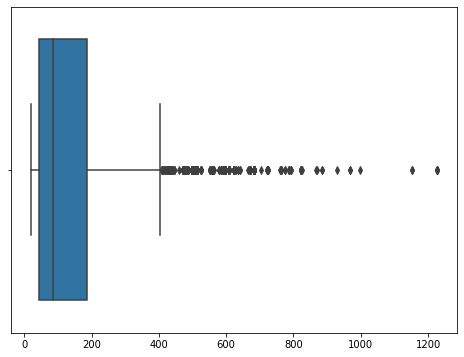

In [14]:
import seaborn as sns

plt.figure(figsize = (8,6))
sns.boxplot(x = session_length_df[0], data = session_length)

In [15]:
# 세션 수(클릭 수) 상위 99% 까지의 수 및 누적(%)
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]
length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

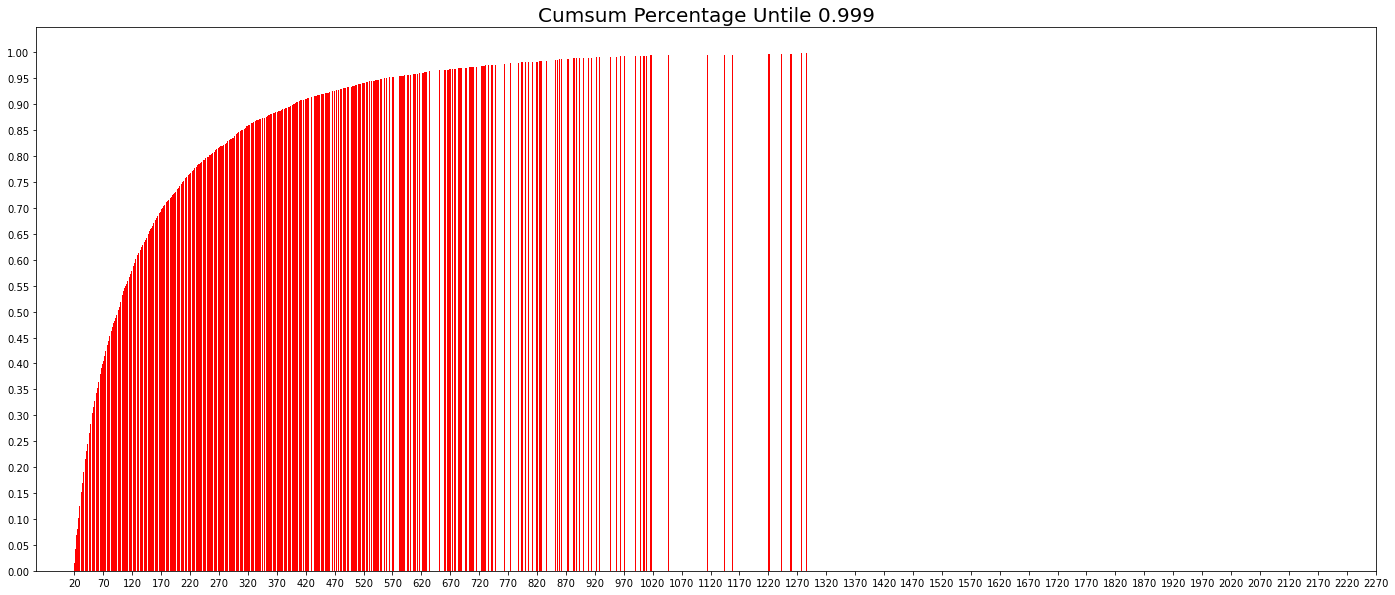

In [16]:
# 세션 수(클릭 수) 집계 시각화

import matplotlib.pyplot as plt

plt.figure(figsize=(24,10))
plt.bar(x = length_percent_cumsum_999.index,
        height = length_percent_cumsum_999, color = 'red')
plt.xticks(np.arange(session_length.min(),session_length.max(),50))
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Untile 0.999', size = 20)
plt.show()

## Session Time

In [17]:
# UTC Time 형태의 timestamp를 unix 형태로 변경하여 사칙 연산이 가능하도록 datetime 라이브러리 이용
data['Time']=data['Time'].apply(lambda x: dt.datetime.utcfromtimestamp(int(x)))

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   UserId  1000209 non-null  int32         
 1   ItemId  1000209 non-null  int32         
 2   Rating  1000209 non-null  int32         
 3   Time    1000209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(3)
memory usage: 26.7 MB


In [19]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


## Data Cleansing

In [20]:
# 유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 길이가 1인 세션은 제거한다.
# 너무 적게 클릭된 아이템은 이상한 아이템일 가능성이 높다. 제거한다.

# short_session 을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있다.
# 이를 위해 반복문을 통해 지속적으로 제거한다.

# '-> pd.DataFrame' 은 이 정희하는 함수는 'pd.DataFrame'을 return(반환)하는 함수를 뜻 한다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data

def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [21]:
# 한 유저가 최소 시청 횟수가 20이하이인 데이터는 제거한다.
# 9명의 유저 이하의 시청률만 보이는 영화는 제거한다.
data = cleanse_recursive(data, shortest = 20, least_click = 10)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


## 세션의 정의
  * 실습예제에서 수행했던 세션은 한 번 접속했을 때 기준이다. 로그인/로그아웃 기준이 아니므로, 접속을 끊게 되면 세션은 종료된다. 따라서, train/validation/test set의 분류 기준을 Timestamp 기준으로 하였다.
  * 본 프로젝트에서 세션의 기준은 UserId 기준으로 정하여 train/validation/test set의 분류 기준역시 UserId 기준으로 한다.

## Train/Validation/Test split

### Train data

In [22]:
# 현재 data set의 데이터 정렬기준이 UserId 기준이므로 6:2:2 기준으로 분류한다음, UserId 별로 나뉠수 있게 재조정한다.
data.sort_values(['UserId'], inplace=True)
data=data.reset_index(drop=True)
data

,UserId,ItemId,Rating,Time
0,1,3186,4,2000-12-31 22:00:19
1,1,1246,4,2000-12-31 22:34:51
2,1,661,3,2000-12-31 22:35:09
3,1,2918,4,2000-12-31 22:35:24
4,1,531,4,2000-12-31 22:35:49
...,...,...,...,...
998423,6040,1096,4,2000-04-26 02:20:48
998424,6040,1079,2,2000-04-26 02:20:48
998425,6040,2348,2,2000-04-26 02:20:48
998426,6040,3070,3,2000-04-26 02:23:25


In [23]:
# Train set
tr = data[:int(round(len(data)*0.6,0))]
tr

,UserId,ItemId,Rating,Time
0,1,3186,4,2000-12-31 22:00:19
1,1,1246,4,2000-12-31 22:34:51
2,1,661,3,2000-12-31 22:35:09
3,1,2918,4,2000-12-31 22:35:24
4,1,531,4,2000-12-31 22:35:49
...,...,...,...,...
599052,3650,2968,3,2000-08-16 20:10:51
599053,3650,3408,4,2000-08-16 20:12:28
599054,3650,3147,4,2000-08-16 20:12:28
599055,3650,3186,2,2000-08-16 20:12:28


In [24]:
data[data['UserId']==3650]

,UserId,ItemId,Rating,Time
598531,3650,368,4,2000-10-05 18:59:44
598532,3650,316,3,2000-10-05 18:59:44
598533,3650,2533,4,2000-10-05 18:59:44
598534,3650,1587,4,2000-10-05 18:59:12
598535,3650,3638,5,2000-10-05 18:59:44
...,...,...,...,...
599310,3650,1597,3,2000-08-16 21:05:03
599311,3650,73,4,2000-08-16 21:05:03
599312,3650,450,4,2000-08-16 21:05:33
599313,3650,2605,4,2000-08-16 21:06:00


In [25]:
tr = data[:599315]
tr.tail(3)

,UserId,ItemId,Rating,Time
599312,3650,450,4,2000-08-16 21:05:33
599313,3650,2605,4,2000-08-16 21:06:00
599314,3650,353,5,2000-08-16 21:06:00


### Validation data

In [26]:
val = data[599315:int(len(data)*0.8)]
val

,UserId,ItemId,Rating,Time
599315,3651,3551,4,2000-08-16 21:56:03
599316,3651,373,5,2000-08-16 21:59:55
599317,3651,16,3,2000-08-16 21:59:55
599318,3651,1343,4,2000-08-16 21:59:55
599319,3651,293,4,2000-08-16 21:59:55
...,...,...,...,...
798737,4796,2021,3,2000-07-07 17:09:14
798738,4796,2193,2,2000-07-07 17:09:14
798739,4796,2161,3,2000-07-07 17:09:14
798740,4796,1967,3,2000-07-07 17:08:49


In [27]:
data[data["UserId"]==4796]

,UserId,ItemId,Rating,Time
798713,4796,2803,3,2000-07-07 16:47:16
798714,4796,218,3,2000-07-07 16:44:07
798715,4796,2385,3,2000-07-07 16:47:16
798716,4796,44,3,2000-07-07 16:46:58
798717,4796,3247,4,2000-07-07 16:45:50
...,...,...,...,...
799049,4796,1148,4,2000-07-07 16:03:31
799050,4796,3114,4,2000-07-07 16:02:56
799051,4796,3457,1,2000-07-07 16:02:26
799052,4796,296,4,2000-07-07 16:05:15


In [28]:
val = data[599315:799054]
val.tail(3)

,UserId,ItemId,Rating,Time
799051,4796,3457,1,2000-07-07 16:02:26
799052,4796,296,4,2000-07-07 16:05:15
799053,4796,3328,4,2000-07-07 16:01:21


### test data

In [29]:
test = data[799055:]
test.tail(3)

,UserId,ItemId,Rating,Time
998425,6040,2348,2,2000-04-26 02:20:48
998426,6040,3070,3,2000-04-26 02:23:25
998427,6040,1221,4,2001-08-20 13:44:15


In [30]:
# train set에 없는 아이템이 val, test 기간에 생길 수 있으므로 train data 기준으로 인덱싱 한다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [31]:
print(f'train data 길이: {len(tr)}')
print(f'validation data 길이: {len(val)}')
print(f'test data 길이: {len(test)}')

train data 길이: 599315
validation data 길이: 199739
test data 길이: 199373


In [32]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# Step 2. 미니 배치의 구성

## SessionDataset

In [33]:
class SessionDataset:
  """Credit to yhs-968/pyGRU4REC."""

  def __init__(self, data):
    self.df = data
    self.click_offsets = self.get_click_offsets()
    # indexing to UserId
    self.session_idx = np.arange(self.df['UserId'].nunique())

  def get_click_offsets(self):
    """
    Return the indexes of the first click of each session IDs,
    """
    offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
    offsets[1:] = self.df.groupby('UserId').size().cumsum()
    return offsets

In [34]:
# click_offsets : 각 세션이 시작된 인덱스를 담고 있다.
# session_idx : 각 세션을 인덱싱한 np.array 이다.

tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1246,4,2000-12-31 22:34:51,1
2,1,661,3,2000-12-31 22:35:09,2
3,1,2918,4,2000-12-31 22:35:24,3
4,1,531,4,2000-12-31 22:35:49,4
5,1,3114,4,2000-12-31 22:36:14,5
6,1,2791,4,2000-12-31 22:36:28,6
7,1,2321,3,2000-12-31 22:36:45,7
8,1,1029,5,2000-12-31 22:36:45,8
9,1,1197,3,2000-12-31 22:37:48,9


In [35]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 598480, 598531, 599315], dtype=int32)

In [36]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 3643, 3644, 3645])

In [37]:
tr_dataset.df.nunique()

UserId        3646
ItemId        3260
Rating           5
Time        271936
item_idx      3260
dtype: int64

## SessionDataLoader

In [38]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [39]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size = 4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1246,4,2000-12-31 22:34:51,1
2,1,661,3,2000-12-31 22:35:09,2
3,1,2918,4,2000-12-31 22:35:24,3
4,1,531,4,2000-12-31 22:35:49,4
5,1,3114,4,2000-12-31 22:36:14,5
6,1,2791,4,2000-12-31 22:36:28,6
7,1,2321,3,2000-12-31 22:36:45,7
8,1,1029,5,2000-12-31 22:36:45,8
9,1,1197,3,2000-12-31 22:37:48,9


In [40]:
iter_ex = iter(tr_data_loader)

In [41]:
inputs, labels, mask = next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  53 175  42]
Label Item Idx are :       [  1  54 176 166]
Previous Masked Input Idx are []


# Step 3. 모델 구성

In [42]:
def mrr_k(pred, truth: int, k: int):
  indexing = np.where(pred[:k] == truth)[0]
  if len(indexing) > 0:
    return 1 / (indexing[0] + 1)
  else:
    return 0

def recall_k(pred, truth: int, k: int) -> int:
  answer = truth in pred[:k]
  return int(answer)

In [43]:
def create_model(args):
  inputs = Input(batch_shape = (args.batch_size, 1, args.num_items))
  gru, _ = GRU(args.hsz, stateful = True, return_state = True, name = 'GRU')(inputs)
  dropout = Dropout(args.drop_rate)(gru)
  predictions = Dense(args.num_items, activation = 'softmax')(dropout)
  model = Model(inputs = inputs, outputs = [predictions])
  model.compile(loss = categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
  model.summary()
  return model

In [44]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [45]:
model = create_model(args)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(256, 1, 3260)]          0         
                                                                 
 GRU (GRU)                   [(256, 50),               496800    
                              (256, 50)]                         
                                                                 
 dropout (Dropout)           (256, 50)                 0         
                                                                 
 dense (Dense)               (256, 3260)               166260    
                                                                 
Total params: 663,060
Trainable params: 663,060
Non-trainable params: 0
_________________________________________________________________


# Step 4. 모델 학습

In [46]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [47]:
train_model(model, args)

Evaluation:   0%|          | 0/775 [00:00<?, ?it/s]

1/1 [==============================] - 0s 303ms/step


Evaluation:   0%|          | 1/775 [00:02<30:03,  2.33s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   0%|          | 2/775 [00:04<27:33,  2.14s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   0%|          | 3/775 [00:06<26:35,  2.07s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   1%|          | 4/775 [00:08<26:13,  2.04s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   1%|          | 5/775 [00:10<25:55,  2.02s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   1%|          | 6/775 [00:12<25:52,  2.02s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   1%|          | 7/775 [00:14<25:24,  1.98s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   1%|          | 8/775 [00:16<24:57,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   1%|          | 9/775 [00:18<24:55,  1.95s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   1%|▏         | 10/775 [00:19<24:46,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   1%|▏         | 11/775 [00:21<24:45,  1.94s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:   2%|▏         | 12/775 [00:23<24:44,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   2%|▏         | 13/775 [00:25<24:34,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   2%|▏         | 14/775 [00:27<24:51,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   2%|▏         | 15/775 [00:29<24:42,  1.95s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   2%|▏         | 16/775 [00:31<24:41,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   2%|▏         | 17/775 [00:33<24:32,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   2%|▏         | 18/775 [00:35<24:24,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   2%|▏         | 19/775 [00:37<24:24,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   3%|▎         | 20/775 [00:39<24:28,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   3%|▎         | 21/775 [00:41<24:18,  1.93s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   3%|▎         | 22/775 [00:43<24:14,  1.93s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   3%|▎         | 23/775 [00:45<24:11,  1.93s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   3%|▎         | 24/775 [00:47<24:15,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   3%|▎         | 25/775 [00:49<24:10,  1.93s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   3%|▎         | 26/775 [00:51<24:21,  1.95s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:   3%|▎         | 27/775 [00:52<24:08,  1.94s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   4%|▎         | 28/775 [00:54<24:00,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   4%|▎         | 29/775 [00:56<23:58,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   4%|▍         | 30/775 [00:59<25:48,  2.08s/it]

1/1 [==============================] - 0s 28ms/step


Evaluation:   4%|▍         | 31/775 [01:01<27:19,  2.20s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:   4%|▍         | 32/775 [01:03<26:09,  2.11s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   4%|▍         | 33/775 [01:05<25:25,  2.06s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   4%|▍         | 34/775 [01:07<25:09,  2.04s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   5%|▍         | 35/775 [01:09<24:45,  2.01s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:   5%|▍         | 36/775 [01:11<24:26,  1.98s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   5%|▍         | 37/775 [01:13<24:14,  1.97s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   5%|▍         | 38/775 [01:15<24:11,  1.97s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   5%|▌         | 39/775 [01:17<24:13,  1.98s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   5%|▌         | 40/775 [01:19<24:00,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   5%|▌         | 41/775 [01:21<23:56,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   5%|▌         | 42/775 [01:23<23:58,  1.96s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:   6%|▌         | 43/775 [01:25<23:44,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   6%|▌         | 44/775 [01:26<23:36,  1.94s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:   6%|▌         | 45/775 [01:28<23:40,  1.95s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   6%|▌         | 46/775 [01:30<23:34,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   6%|▌         | 47/775 [01:32<23:30,  1.94s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   6%|▌         | 48/775 [01:34<23:19,  1.92s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   6%|▋         | 49/775 [01:36<23:16,  1.92s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   6%|▋         | 50/775 [01:38<23:08,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   7%|▋         | 51/775 [01:40<23:07,  1.92s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   7%|▋         | 52/775 [01:42<23:05,  1.92s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   7%|▋         | 53/775 [01:44<23:00,  1.91s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   7%|▋         | 54/775 [01:46<23:04,  1.92s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   7%|▋         | 55/775 [01:48<22:58,  1.91s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   7%|▋         | 56/775 [01:50<23:07,  1.93s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   7%|▋         | 57/775 [01:51<23:01,  1.92s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   7%|▋         | 58/775 [01:53<22:58,  1.92s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   8%|▊         | 59/775 [01:55<22:55,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   8%|▊         | 60/775 [01:57<23:06,  1.94s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:   8%|▊         | 61/775 [01:59<23:19,  1.96s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:   8%|▊         | 62/775 [02:01<23:08,  1.95s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   8%|▊         | 63/775 [02:03<23:05,  1.95s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   8%|▊         | 64/775 [02:05<22:56,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   8%|▊         | 65/775 [02:07<23:00,  1.94s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:   9%|▊         | 66/775 [02:09<22:55,  1.94s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   9%|▊         | 67/775 [02:11<22:35,  1.91s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   9%|▉         | 68/775 [02:13<22:33,  1.91s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   9%|▉         | 69/775 [02:15<22:31,  1.91s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   9%|▉         | 70/775 [02:17<22:30,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   9%|▉         | 71/775 [02:19<22:29,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   9%|▉         | 72/775 [02:20<22:29,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   9%|▉         | 73/775 [02:22<22:31,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  10%|▉         | 74/775 [02:24<22:35,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  10%|▉         | 75/775 [02:26<22:38,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  10%|▉         | 76/775 [02:28<22:35,  1.94s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  10%|▉         | 77/775 [02:30<22:40,  1.95s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  10%|█         | 78/775 [02:32<22:29,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  10%|█         | 79/775 [02:34<22:30,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  10%|█         | 80/775 [02:36<22:27,  1.94s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  10%|█         | 81/775 [02:38<22:07,  1.91s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  11%|█         | 82/775 [02:40<22:08,  1.92s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  11%|█         | 83/775 [02:42<22:07,  1.92s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  11%|█         | 84/775 [02:44<22:06,  1.92s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  11%|█         | 85/775 [02:46<22:03,  1.92s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  11%|█         | 86/775 [02:47<22:11,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  11%|█         | 87/775 [02:49<22:15,  1.94s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  11%|█▏        | 88/775 [02:51<22:09,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  11%|█▏        | 89/775 [02:53<22:08,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  12%|█▏        | 90/775 [02:55<22:04,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  12%|█▏        | 91/775 [02:57<22:03,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  12%|█▏        | 92/775 [02:59<22:13,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  12%|█▏        | 93/775 [03:01<22:10,  1.95s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  12%|█▏        | 94/775 [03:03<22:03,  1.94s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  12%|█▏        | 95/775 [03:05<22:02,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  12%|█▏        | 96/775 [03:07<21:56,  1.94s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  13%|█▎        | 97/775 [03:09<21:51,  1.93s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  13%|█▎        | 98/775 [03:11<21:51,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  13%|█▎        | 99/775 [03:13<21:45,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  13%|█▎        | 100/775 [03:15<21:55,  1.95s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  13%|█▎        | 101/775 [03:17<21:54,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  13%|█▎        | 102/775 [03:19<21:46,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  13%|█▎        | 103/775 [03:21<21:47,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  13%|█▎        | 104/775 [03:22<21:48,  1.95s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  14%|█▎        | 105/775 [03:24<21:43,  1.95s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  14%|█▎        | 106/775 [03:26<21:30,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  14%|█▍        | 107/775 [03:28<21:26,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  14%|█▍        | 108/775 [03:30<21:56,  1.97s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  14%|█▍        | 109/775 [03:32<21:49,  1.97s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  14%|█▍        | 110/775 [03:34<21:42,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  14%|█▍        | 111/775 [03:36<21:36,  1.95s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  14%|█▍        | 112/775 [03:38<21:30,  1.95s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  15%|█▍        | 113/775 [03:40<21:32,  1.95s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  15%|█▍        | 114/775 [03:42<21:19,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  15%|█▍        | 115/775 [03:44<21:08,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  15%|█▍        | 116/775 [03:46<21:06,  1.92s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  15%|█▌        | 117/775 [03:48<20:59,  1.91s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  15%|█▌        | 118/775 [03:50<21:06,  1.93s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  15%|█▌        | 119/775 [03:51<21:01,  1.92s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  15%|█▌        | 120/775 [03:53<21:01,  1.93s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  16%|█▌        | 121/775 [03:55<21:19,  1.96s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  16%|█▌        | 122/775 [03:57<21:17,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  16%|█▌        | 123/775 [03:59<21:27,  1.98s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  16%|█▌        | 124/775 [04:01<21:19,  1.97s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  16%|█▌        | 125/775 [04:03<21:16,  1.96s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  16%|█▋        | 126/775 [04:05<21:13,  1.96s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  16%|█▋        | 127/775 [04:07<21:14,  1.97s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  17%|█▋        | 128/775 [04:09<21:07,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  17%|█▋        | 129/775 [04:11<21:16,  1.98s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  17%|█▋        | 130/775 [04:13<21:13,  1.97s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  17%|█▋        | 131/775 [04:15<21:07,  1.97s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  17%|█▋        | 132/775 [04:17<21:07,  1.97s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  17%|█▋        | 133/775 [04:19<21:06,  1.97s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  17%|█▋        | 134/775 [04:21<20:55,  1.96s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  17%|█▋        | 135/775 [04:23<20:55,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  18%|█▊        | 136/775 [04:25<20:52,  1.96s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  18%|█▊        | 137/775 [04:27<20:48,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  18%|█▊        | 138/775 [04:29<20:37,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  18%|█▊        | 139/775 [04:31<20:55,  1.97s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  18%|█▊        | 140/775 [04:33<20:44,  1.96s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  18%|█▊        | 141/775 [04:35<20:40,  1.96s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  18%|█▊        | 142/775 [04:37<20:27,  1.94s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  18%|█▊        | 143/775 [04:39<20:23,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  19%|█▊        | 144/775 [04:40<20:16,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  19%|█▊        | 145/775 [04:42<20:11,  1.92s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  19%|█▉        | 146/775 [04:44<20:12,  1.93s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  19%|█▉        | 147/775 [04:46<20:13,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  19%|█▉        | 148/775 [04:48<20:11,  1.93s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  19%|█▉        | 149/775 [04:50<20:10,  1.93s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  19%|█▉        | 150/775 [04:52<20:12,  1.94s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  19%|█▉        | 151/775 [04:54<20:12,  1.94s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  20%|█▉        | 152/775 [04:56<20:12,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  20%|█▉        | 153/775 [04:59<22:21,  2.16s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  20%|█▉        | 154/775 [05:01<22:38,  2.19s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  20%|██        | 155/775 [05:03<21:52,  2.12s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  20%|██        | 156/775 [05:05<21:23,  2.07s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  20%|██        | 157/775 [05:07<20:46,  2.02s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  20%|██        | 158/775 [05:09<20:33,  2.00s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  21%|██        | 159/775 [05:11<20:27,  1.99s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  21%|██        | 160/775 [05:13<20:09,  1.97s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  21%|██        | 161/775 [05:14<20:01,  1.96s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  21%|██        | 162/775 [05:16<19:52,  1.95s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  21%|██        | 163/775 [05:18<19:48,  1.94s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  21%|██        | 164/775 [05:20<19:48,  1.95s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  21%|██▏       | 165/775 [05:22<19:50,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  21%|██▏       | 166/775 [05:24<19:45,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  22%|██▏       | 167/775 [05:26<19:51,  1.96s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  22%|██▏       | 168/775 [05:28<19:44,  1.95s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  22%|██▏       | 169/775 [05:30<19:49,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  22%|██▏       | 170/775 [05:32<19:51,  1.97s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  22%|██▏       | 171/775 [05:34<19:55,  1.98s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  22%|██▏       | 172/775 [05:36<19:41,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  22%|██▏       | 173/775 [05:38<19:32,  1.95s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  22%|██▏       | 174/775 [05:40<19:23,  1.94s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  23%|██▎       | 175/775 [05:42<19:23,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  23%|██▎       | 176/775 [05:44<19:20,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  23%|██▎       | 177/775 [05:46<19:14,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  23%|██▎       | 178/775 [05:48<19:08,  1.92s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  23%|██▎       | 179/775 [05:50<19:14,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  23%|██▎       | 180/775 [05:51<19:07,  1.93s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  23%|██▎       | 181/775 [05:53<19:12,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  23%|██▎       | 182/775 [05:55<19:06,  1.93s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  24%|██▎       | 183/775 [05:57<19:04,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  24%|██▎       | 184/775 [05:59<19:13,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  24%|██▍       | 185/775 [06:01<19:23,  1.97s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  24%|██▍       | 186/775 [06:03<19:29,  1.99s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  24%|██▍       | 187/775 [06:05<19:18,  1.97s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  24%|██▍       | 188/775 [06:07<19:15,  1.97s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  24%|██▍       | 189/775 [06:09<19:08,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  25%|██▍       | 190/775 [06:11<19:15,  1.98s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  25%|██▍       | 191/775 [06:13<19:05,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  25%|██▍       | 192/775 [06:15<19:01,  1.96s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  25%|██▍       | 193/775 [06:17<18:55,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  25%|██▌       | 194/775 [06:19<18:48,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  25%|██▌       | 195/775 [06:21<18:47,  1.94s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  25%|██▌       | 196/775 [06:23<18:48,  1.95s/it]

1/1 [==============================] - 0s 24ms/step


Evaluation:  25%|██▌       | 197/775 [06:25<18:48,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  26%|██▌       | 198/775 [06:27<18:53,  1.97s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  26%|██▌       | 199/775 [06:29<18:51,  1.96s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  26%|██▌       | 200/775 [06:31<18:50,  1.97s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  26%|██▌       | 201/775 [06:33<19:00,  1.99s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  26%|██▌       | 202/775 [06:35<18:52,  1.98s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  26%|██▌       | 203/775 [06:37<18:37,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  26%|██▋       | 204/775 [06:38<18:25,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  26%|██▋       | 205/775 [06:40<18:20,  1.93s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  27%|██▋       | 206/775 [06:42<18:23,  1.94s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  27%|██▋       | 207/775 [06:44<18:23,  1.94s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  27%|██▋       | 208/775 [06:46<18:23,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  27%|██▋       | 209/775 [06:48<18:19,  1.94s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  27%|██▋       | 210/775 [06:50<18:29,  1.96s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  27%|██▋       | 211/775 [06:52<18:29,  1.97s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  27%|██▋       | 212/775 [06:54<18:34,  1.98s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  27%|██▋       | 213/775 [06:56<18:22,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  28%|██▊       | 214/775 [06:58<18:22,  1.97s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  28%|██▊       | 215/775 [07:00<18:15,  1.96s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  28%|██▊       | 216/775 [07:02<18:14,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  28%|██▊       | 217/775 [07:04<18:22,  1.98s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  28%|██▊       | 218/775 [07:06<18:22,  1.98s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  28%|██▊       | 219/775 [07:08<18:12,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  28%|██▊       | 220/775 [07:10<18:13,  1.97s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  29%|██▊       | 221/775 [07:12<18:08,  1.96s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  29%|██▊       | 222/775 [07:14<18:03,  1.96s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  29%|██▉       | 223/775 [07:16<18:05,  1.97s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  29%|██▉       | 224/775 [07:18<17:56,  1.95s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  29%|██▉       | 225/775 [07:20<17:54,  1.95s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  29%|██▉       | 226/775 [07:22<17:51,  1.95s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  29%|██▉       | 227/775 [07:24<17:53,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  29%|██▉       | 228/775 [07:25<17:51,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  30%|██▉       | 229/775 [07:27<17:43,  1.95s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  30%|██▉       | 230/775 [07:29<17:27,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  30%|██▉       | 231/775 [07:31<17:31,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  30%|██▉       | 232/775 [07:33<17:51,  1.97s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  30%|███       | 233/775 [07:35<17:46,  1.97s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  30%|███       | 234/775 [07:37<17:40,  1.96s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  30%|███       | 235/775 [07:39<17:32,  1.95s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  30%|███       | 236/775 [07:41<17:27,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  31%|███       | 237/775 [07:43<17:26,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  31%|███       | 238/775 [07:45<17:22,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  31%|███       | 239/775 [07:47<17:22,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  31%|███       | 240/775 [07:49<17:19,  1.94s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  31%|███       | 241/775 [07:51<17:20,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  31%|███       | 242/775 [07:53<17:24,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  31%|███▏      | 243/775 [07:55<17:22,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  31%|███▏      | 244/775 [07:57<17:20,  1.96s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  32%|███▏      | 245/775 [07:59<17:16,  1.96s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  32%|███▏      | 246/775 [08:01<17:07,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  32%|███▏      | 247/775 [08:02<17:01,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  32%|███▏      | 248/775 [08:04<17:13,  1.96s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  32%|███▏      | 249/775 [08:06<17:08,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  32%|███▏      | 250/775 [08:08<16:59,  1.94s/it]

1/1 [==============================] - 0s 24ms/step


Evaluation:  32%|███▏      | 251/775 [08:10<17:06,  1.96s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  33%|███▎      | 252/775 [08:12<16:59,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  33%|███▎      | 253/775 [08:14<17:00,  1.96s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  33%|███▎      | 254/775 [08:16<17:05,  1.97s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  33%|███▎      | 255/775 [08:18<17:00,  1.96s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  33%|███▎      | 256/775 [08:20<17:03,  1.97s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  33%|███▎      | 257/775 [08:22<16:55,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  33%|███▎      | 258/775 [08:24<16:58,  1.97s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  33%|███▎      | 259/775 [08:26<16:54,  1.97s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  34%|███▎      | 260/775 [08:28<16:51,  1.96s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  34%|███▎      | 261/775 [08:30<16:39,  1.95s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  34%|███▍      | 262/775 [08:32<16:33,  1.94s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  34%|███▍      | 263/775 [08:34<16:33,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  34%|███▍      | 264/775 [08:36<16:25,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  34%|███▍      | 265/775 [08:38<16:30,  1.94s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  34%|███▍      | 266/775 [08:40<16:24,  1.93s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  34%|███▍      | 267/775 [08:42<16:24,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  35%|███▍      | 268/775 [08:43<16:20,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  35%|███▍      | 269/775 [08:45<16:16,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  35%|███▍      | 270/775 [08:47<16:13,  1.93s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  35%|███▍      | 271/775 [08:49<16:14,  1.93s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  35%|███▌      | 272/775 [08:51<16:15,  1.94s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  35%|███▌      | 273/775 [08:53<16:19,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  35%|███▌      | 274/775 [08:55<17:08,  2.05s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  35%|███▌      | 275/775 [08:58<18:31,  2.22s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  36%|███▌      | 276/775 [09:00<17:55,  2.16s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  36%|███▌      | 277/775 [09:02<17:21,  2.09s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  36%|███▌      | 278/775 [09:04<16:57,  2.05s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  36%|███▌      | 279/775 [09:06<16:41,  2.02s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  36%|███▌      | 280/775 [09:08<16:32,  2.01s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  36%|███▋      | 281/775 [09:10<16:19,  1.98s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  36%|███▋      | 282/775 [09:12<16:05,  1.96s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  37%|███▋      | 283/775 [09:14<16:05,  1.96s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  37%|███▋      | 284/775 [09:16<15:55,  1.95s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  37%|███▋      | 285/775 [09:18<15:56,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  37%|███▋      | 286/775 [09:20<15:54,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  37%|███▋      | 287/775 [09:22<15:56,  1.96s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  37%|███▋      | 288/775 [09:23<15:51,  1.95s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  37%|███▋      | 289/775 [09:25<15:49,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  37%|███▋      | 290/775 [09:27<15:46,  1.95s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  38%|███▊      | 291/775 [09:29<15:41,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  38%|███▊      | 292/775 [09:31<15:37,  1.94s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  38%|███▊      | 293/775 [09:33<15:38,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  38%|███▊      | 294/775 [09:35<15:37,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  38%|███▊      | 295/775 [09:37<15:33,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  38%|███▊      | 296/775 [09:39<15:36,  1.95s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  38%|███▊      | 297/775 [09:41<15:33,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  38%|███▊      | 298/775 [09:43<15:28,  1.95s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  39%|███▊      | 299/775 [09:45<15:25,  1.95s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  39%|███▊      | 300/775 [09:47<15:23,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  39%|███▉      | 301/775 [09:49<15:19,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  39%|███▉      | 302/775 [09:51<15:23,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  39%|███▉      | 303/775 [09:53<15:20,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  39%|███▉      | 304/775 [09:55<15:13,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  39%|███▉      | 305/775 [09:57<15:12,  1.94s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  39%|███▉      | 306/775 [09:58<15:11,  1.94s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  40%|███▉      | 307/775 [10:00<15:07,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  40%|███▉      | 308/775 [10:02<15:06,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  40%|███▉      | 309/775 [10:04<15:01,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  40%|████      | 310/775 [10:06<15:01,  1.94s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  40%|████      | 311/775 [10:08<15:10,  1.96s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  40%|████      | 312/775 [10:10<15:04,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  40%|████      | 313/775 [10:12<14:57,  1.94s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  41%|████      | 314/775 [10:14<14:54,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  41%|████      | 315/775 [10:16<14:55,  1.95s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  41%|████      | 316/775 [10:18<14:51,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  41%|████      | 317/775 [10:20<14:51,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  41%|████      | 318/775 [10:22<14:44,  1.94s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  41%|████      | 319/775 [10:24<14:40,  1.93s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  41%|████▏     | 320/775 [10:26<14:43,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  41%|████▏     | 321/775 [10:28<14:40,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  42%|████▏     | 322/775 [10:29<14:33,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  42%|████▏     | 323/775 [10:31<14:34,  1.93s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  42%|████▏     | 324/775 [10:33<14:31,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  42%|████▏     | 325/775 [10:35<14:24,  1.92s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  42%|████▏     | 326/775 [10:37<14:20,  1.92s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  42%|████▏     | 327/775 [10:39<14:29,  1.94s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  42%|████▏     | 328/775 [10:41<14:26,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  42%|████▏     | 329/775 [10:43<14:27,  1.95s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  43%|████▎     | 330/775 [10:45<14:24,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  43%|████▎     | 331/775 [10:47<14:23,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  43%|████▎     | 332/775 [10:49<14:23,  1.95s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  43%|████▎     | 333/775 [10:51<14:26,  1.96s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  43%|████▎     | 334/775 [10:53<14:19,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  43%|████▎     | 335/775 [10:55<14:17,  1.95s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  43%|████▎     | 336/775 [10:57<14:14,  1.95s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  43%|████▎     | 337/775 [10:59<14:12,  1.95s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  44%|████▎     | 338/775 [11:01<14:07,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  44%|████▎     | 339/775 [11:02<14:02,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  44%|████▍     | 340/775 [11:04<14:00,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  44%|████▍     | 341/775 [11:06<14:00,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  44%|████▍     | 342/775 [11:08<14:00,  1.94s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  44%|████▍     | 343/775 [11:10<14:06,  1.96s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  44%|████▍     | 344/775 [11:12<13:54,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  45%|████▍     | 345/775 [11:14<13:49,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  45%|████▍     | 346/775 [11:16<13:48,  1.93s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  45%|████▍     | 347/775 [11:18<13:43,  1.92s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  45%|████▍     | 348/775 [11:20<13:42,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  45%|████▌     | 349/775 [11:22<13:37,  1.92s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  45%|████▌     | 350/775 [11:24<13:32,  1.91s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  45%|████▌     | 351/775 [11:26<13:33,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  45%|████▌     | 352/775 [11:28<13:30,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  46%|████▌     | 353/775 [11:29<13:31,  1.92s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  46%|████▌     | 354/775 [11:31<13:38,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  46%|████▌     | 355/775 [11:33<13:36,  1.94s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  46%|████▌     | 356/775 [11:35<13:41,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  46%|████▌     | 357/775 [11:37<13:38,  1.96s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  46%|████▌     | 358/775 [11:39<13:44,  1.98s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  46%|████▋     | 359/775 [11:41<13:40,  1.97s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  46%|████▋     | 360/775 [11:43<13:28,  1.95s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  47%|████▋     | 361/775 [11:45<13:23,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  47%|████▋     | 362/775 [11:47<13:19,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  47%|████▋     | 363/775 [11:49<13:20,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  47%|████▋     | 364/775 [11:51<13:17,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  47%|████▋     | 365/775 [11:53<13:18,  1.95s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  47%|████▋     | 366/775 [11:55<13:10,  1.93s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  47%|████▋     | 367/775 [11:57<13:07,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  47%|████▋     | 368/775 [11:59<13:06,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  48%|████▊     | 369/775 [12:01<13:07,  1.94s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  48%|████▊     | 370/775 [12:03<13:02,  1.93s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  48%|████▊     | 371/775 [12:05<13:02,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  48%|████▊     | 372/775 [12:06<12:57,  1.93s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  48%|████▊     | 373/775 [12:08<12:57,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  48%|████▊     | 374/775 [12:10<12:57,  1.94s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  48%|████▊     | 375/775 [12:12<12:59,  1.95s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  49%|████▊     | 376/775 [12:14<12:56,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  49%|████▊     | 377/775 [12:16<12:48,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  49%|████▉     | 378/775 [12:18<12:53,  1.95s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  49%|████▉     | 379/775 [12:20<12:50,  1.95s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  49%|████▉     | 380/775 [12:22<12:45,  1.94s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  49%|████▉     | 381/775 [12:24<12:44,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  49%|████▉     | 382/775 [12:26<12:41,  1.94s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  49%|████▉     | 383/775 [12:28<12:39,  1.94s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  50%|████▉     | 384/775 [12:30<12:37,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  50%|████▉     | 385/775 [12:32<12:34,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  50%|████▉     | 386/775 [12:34<12:32,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  50%|████▉     | 387/775 [12:36<12:31,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  50%|█████     | 388/775 [12:37<12:29,  1.94s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  50%|█████     | 389/775 [12:39<12:21,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  50%|█████     | 390/775 [12:41<12:23,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  50%|█████     | 391/775 [12:43<12:20,  1.93s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  51%|█████     | 392/775 [12:45<12:23,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  51%|█████     | 393/775 [12:47<12:21,  1.94s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  51%|█████     | 394/775 [12:49<12:20,  1.94s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  51%|█████     | 395/775 [12:51<12:20,  1.95s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  51%|█████     | 396/775 [12:53<12:19,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  51%|█████     | 397/775 [12:55<12:17,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  51%|█████▏    | 398/775 [12:57<13:01,  2.07s/it]

1/1 [==============================] - 0s 26ms/step


Evaluation:  51%|█████▏    | 399/775 [13:00<13:42,  2.19s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  52%|█████▏    | 400/775 [13:02<13:07,  2.10s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  52%|█████▏    | 401/775 [13:04<12:52,  2.07s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  52%|█████▏    | 402/775 [13:06<12:32,  2.02s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  52%|█████▏    | 403/775 [13:07<12:21,  1.99s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  52%|█████▏    | 404/775 [13:09<12:14,  1.98s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  52%|█████▏    | 405/775 [13:11<12:12,  1.98s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  52%|█████▏    | 406/775 [13:13<12:04,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  53%|█████▎    | 407/775 [13:15<11:57,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  53%|█████▎    | 408/775 [13:17<11:50,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  53%|█████▎    | 409/775 [13:19<11:51,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  53%|█████▎    | 410/775 [13:21<11:52,  1.95s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  53%|█████▎    | 411/775 [13:23<11:54,  1.96s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  53%|█████▎    | 412/775 [13:25<11:46,  1.95s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  53%|█████▎    | 413/775 [13:27<11:40,  1.93s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  53%|█████▎    | 414/775 [13:29<11:35,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  54%|█████▎    | 415/775 [13:31<11:34,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  54%|█████▎    | 416/775 [13:33<11:35,  1.94s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  54%|█████▍    | 417/775 [13:35<11:35,  1.94s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  54%|█████▍    | 418/775 [13:37<11:34,  1.95s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  54%|█████▍    | 419/775 [13:39<11:27,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  54%|█████▍    | 420/775 [13:40<11:28,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  54%|█████▍    | 421/775 [13:42<11:27,  1.94s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  54%|█████▍    | 422/775 [13:44<11:22,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  55%|█████▍    | 423/775 [13:46<11:19,  1.93s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  55%|█████▍    | 424/775 [13:48<11:16,  1.93s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  55%|█████▍    | 425/775 [13:50<11:15,  1.93s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  55%|█████▍    | 426/775 [13:52<11:13,  1.93s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  55%|█████▌    | 427/775 [13:54<11:13,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  55%|█████▌    | 428/775 [13:56<11:24,  1.97s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  55%|█████▌    | 429/775 [13:58<11:18,  1.96s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  55%|█████▌    | 430/775 [14:00<11:16,  1.96s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  56%|█████▌    | 431/775 [14:02<11:09,  1.95s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  56%|█████▌    | 432/775 [14:04<11:09,  1.95s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  56%|█████▌    | 433/775 [14:06<11:05,  1.95s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  56%|█████▌    | 434/775 [14:08<11:03,  1.95s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  56%|█████▌    | 435/775 [14:10<10:59,  1.94s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  56%|█████▋    | 436/775 [14:12<10:57,  1.94s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  56%|█████▋    | 437/775 [14:14<10:59,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  57%|█████▋    | 438/775 [14:15<10:50,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  57%|█████▋    | 439/775 [14:17<10:46,  1.92s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  57%|█████▋    | 440/775 [14:19<10:44,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  57%|█████▋    | 441/775 [14:21<10:45,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  57%|█████▋    | 442/775 [14:23<10:41,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  57%|█████▋    | 443/775 [14:25<10:38,  1.92s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  57%|█████▋    | 444/775 [14:27<10:35,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  57%|█████▋    | 445/775 [14:29<10:33,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  58%|█████▊    | 446/775 [14:31<10:30,  1.92s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  58%|█████▊    | 447/775 [14:33<10:31,  1.92s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  58%|█████▊    | 448/775 [14:35<10:29,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  58%|█████▊    | 449/775 [14:37<10:29,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  58%|█████▊    | 450/775 [14:38<10:22,  1.91s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  58%|█████▊    | 451/775 [14:40<10:18,  1.91s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  58%|█████▊    | 452/775 [14:42<10:26,  1.94s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  58%|█████▊    | 453/775 [14:44<10:26,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  59%|█████▊    | 454/775 [14:46<10:20,  1.93s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  59%|█████▊    | 455/775 [14:48<10:12,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  59%|█████▉    | 456/775 [14:50<10:08,  1.91s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  59%|█████▉    | 457/775 [14:52<10:13,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  59%|█████▉    | 458/775 [14:54<10:16,  1.94s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  59%|█████▉    | 459/775 [14:56<10:15,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  59%|█████▉    | 460/775 [14:58<10:15,  1.95s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  59%|█████▉    | 461/775 [15:00<10:12,  1.95s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  60%|█████▉    | 462/775 [15:02<10:09,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  60%|█████▉    | 463/775 [15:04<10:08,  1.95s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  60%|█████▉    | 464/775 [15:06<10:03,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  60%|██████    | 465/775 [15:08<10:01,  1.94s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  60%|██████    | 466/775 [15:10<10:00,  1.94s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  60%|██████    | 467/775 [15:11<09:54,  1.93s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  60%|██████    | 468/775 [15:13<10:01,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  61%|██████    | 469/775 [15:15<09:54,  1.94s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  61%|██████    | 470/775 [15:17<09:52,  1.94s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  61%|██████    | 471/775 [15:19<09:49,  1.94s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  61%|██████    | 472/775 [15:21<09:49,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  61%|██████    | 473/775 [15:23<09:46,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  61%|██████    | 474/775 [15:25<09:44,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  61%|██████▏   | 475/775 [15:27<09:40,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  61%|██████▏   | 476/775 [15:29<09:38,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  62%|██████▏   | 477/775 [15:31<09:36,  1.93s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  62%|██████▏   | 478/775 [15:33<09:31,  1.92s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  62%|██████▏   | 479/775 [15:35<09:28,  1.92s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  62%|██████▏   | 480/775 [15:37<09:30,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  62%|██████▏   | 481/775 [15:39<09:27,  1.93s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  62%|██████▏   | 482/775 [15:40<09:24,  1.93s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  62%|██████▏   | 483/775 [15:42<09:22,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  62%|██████▏   | 484/775 [15:44<09:29,  1.96s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  63%|██████▎   | 485/775 [15:46<09:28,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  63%|██████▎   | 486/775 [15:48<09:22,  1.95s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  63%|██████▎   | 487/775 [15:50<09:16,  1.93s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  63%|██████▎   | 488/775 [15:52<09:17,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  63%|██████▎   | 489/775 [15:54<09:16,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  63%|██████▎   | 490/775 [15:56<09:13,  1.94s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  63%|██████▎   | 491/775 [15:58<09:10,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  63%|██████▎   | 492/775 [16:00<09:08,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  64%|██████▎   | 493/775 [16:02<09:07,  1.94s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  64%|██████▎   | 494/775 [16:04<09:06,  1.94s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  64%|██████▍   | 495/775 [16:06<09:04,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  64%|██████▍   | 496/775 [16:08<09:06,  1.96s/it]

1/1 [==============================] - 0s 25ms/step


Evaluation:  64%|██████▍   | 497/775 [16:10<09:02,  1.95s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  64%|██████▍   | 498/775 [16:12<08:59,  1.95s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  64%|██████▍   | 499/775 [16:14<09:01,  1.96s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  65%|██████▍   | 500/775 [16:16<08:56,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  65%|██████▍   | 501/775 [16:18<08:54,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  65%|██████▍   | 502/775 [16:19<08:54,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  65%|██████▍   | 503/775 [16:21<08:49,  1.95s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  65%|██████▌   | 504/775 [16:23<08:47,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  65%|██████▌   | 505/775 [16:25<08:46,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  65%|██████▌   | 506/775 [16:27<08:41,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  65%|██████▌   | 507/775 [16:29<08:43,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  66%|██████▌   | 508/775 [16:31<08:39,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  66%|██████▌   | 509/775 [16:33<08:38,  1.95s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  66%|██████▌   | 510/775 [16:35<08:31,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  66%|██████▌   | 511/775 [16:37<08:29,  1.93s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  66%|██████▌   | 512/775 [16:39<08:29,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  66%|██████▌   | 513/775 [16:41<08:25,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  66%|██████▋   | 514/775 [16:43<08:21,  1.92s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  66%|██████▋   | 515/775 [16:45<08:26,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  67%|██████▋   | 516/775 [16:47<08:24,  1.95s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  67%|██████▋   | 517/775 [16:49<08:25,  1.96s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  67%|██████▋   | 518/775 [16:51<08:21,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  67%|██████▋   | 519/775 [16:53<08:19,  1.95s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  67%|██████▋   | 520/775 [16:54<08:14,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  67%|██████▋   | 521/775 [16:56<08:10,  1.93s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  67%|██████▋   | 522/775 [16:58<08:14,  1.95s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  67%|██████▋   | 523/775 [17:01<09:11,  2.19s/it]

1/1 [==============================] - 0s 24ms/step


Evaluation:  68%|██████▊   | 524/775 [17:03<08:53,  2.12s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  68%|██████▊   | 525/775 [17:05<08:32,  2.05s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  68%|██████▊   | 526/775 [17:07<08:19,  2.01s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  68%|██████▊   | 527/775 [17:09<08:09,  1.98s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  68%|██████▊   | 528/775 [17:11<08:05,  1.97s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  68%|██████▊   | 529/775 [17:13<08:02,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  68%|██████▊   | 530/775 [17:15<08:01,  1.97s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  69%|██████▊   | 531/775 [17:17<07:58,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  69%|██████▊   | 532/775 [17:18<07:54,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  69%|██████▉   | 533/775 [17:20<07:49,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  69%|██████▉   | 534/775 [17:22<07:44,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  69%|██████▉   | 535/775 [17:24<07:44,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  69%|██████▉   | 536/775 [17:26<07:42,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  69%|██████▉   | 537/775 [17:28<07:40,  1.94s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  69%|██████▉   | 538/775 [17:30<07:38,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  70%|██████▉   | 539/775 [17:32<07:36,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  70%|██████▉   | 540/775 [17:34<07:39,  1.95s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  70%|██████▉   | 541/775 [17:36<07:34,  1.94s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  70%|██████▉   | 542/775 [17:38<07:32,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  70%|███████   | 543/775 [17:40<07:30,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  70%|███████   | 544/775 [17:42<07:29,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  70%|███████   | 545/775 [17:44<07:25,  1.94s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  70%|███████   | 546/775 [17:46<07:30,  1.97s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  71%|███████   | 547/775 [17:48<07:29,  1.97s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  71%|███████   | 548/775 [17:50<07:22,  1.95s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  71%|███████   | 549/775 [17:52<07:20,  1.95s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  71%|███████   | 550/775 [17:53<07:14,  1.93s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  71%|███████   | 551/775 [17:55<07:09,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  71%|███████   | 552/775 [17:57<07:07,  1.92s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  71%|███████▏  | 553/775 [17:59<07:06,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  71%|███████▏  | 554/775 [18:01<07:04,  1.92s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  72%|███████▏  | 555/775 [18:03<07:02,  1.92s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  72%|███████▏  | 556/775 [18:05<06:59,  1.92s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  72%|███████▏  | 557/775 [18:07<06:58,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  72%|███████▏  | 558/775 [18:09<06:57,  1.92s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  72%|███████▏  | 559/775 [18:11<06:54,  1.92s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  72%|███████▏  | 560/775 [18:13<06:53,  1.92s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  72%|███████▏  | 561/775 [18:15<06:51,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  73%|███████▎  | 562/775 [18:16<06:49,  1.92s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  73%|███████▎  | 563/775 [18:18<06:48,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  73%|███████▎  | 564/775 [18:20<06:44,  1.92s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  73%|███████▎  | 565/775 [18:22<06:43,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  73%|███████▎  | 566/775 [18:24<06:43,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  73%|███████▎  | 567/775 [18:26<06:41,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  73%|███████▎  | 568/775 [18:28<06:38,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  73%|███████▎  | 569/775 [18:30<06:36,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  74%|███████▎  | 570/775 [18:32<06:31,  1.91s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  74%|███████▎  | 571/775 [18:34<06:30,  1.91s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  74%|███████▍  | 572/775 [18:36<06:29,  1.92s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  74%|███████▍  | 573/775 [18:38<06:27,  1.92s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  74%|███████▍  | 574/775 [18:40<06:27,  1.93s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  74%|███████▍  | 575/775 [18:41<06:23,  1.92s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  74%|███████▍  | 576/775 [18:43<06:20,  1.91s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  74%|███████▍  | 577/775 [18:45<06:16,  1.90s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  75%|███████▍  | 578/775 [18:47<06:14,  1.90s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  75%|███████▍  | 579/775 [18:49<06:18,  1.93s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  75%|███████▍  | 580/775 [18:51<06:20,  1.95s/it]


	 - Recall@20 epoch 1: 0.085836
	 - MRR@20    epoch 1: 0.018653



Evaluation:   0%|          | 0/775 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Evaluation:   0%|          | 1/775 [00:01<24:46,  1.92s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   0%|          | 2/775 [00:03<24:32,  1.90s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   0%|          | 3/775 [00:05<24:15,  1.89s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   1%|          | 4/775 [00:07<23:51,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   1%|          | 5/775 [00:09<23:37,  1.84s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   1%|          | 6/775 [00:11<23:31,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   1%|          | 7/775 [00:12<23:27,  1.83s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   1%|          | 8/775 [00:14<23:34,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   1%|          | 9/775 [00:16<23:44,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   1%|▏         | 10/775 [00:18<23:37,  1.85s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   1%|▏         | 11/775 [00:20<23:38,  1.86s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   2%|▏         | 12/775 [00:22<23:46,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   2%|▏         | 13/775 [00:24<23:36,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   2%|▏         | 14/775 [00:26<23:38,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   2%|▏         | 15/775 [00:27<23:35,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   2%|▏         | 16/775 [00:29<23:45,  1.88s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:   2%|▏         | 17/775 [00:31<23:49,  1.89s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   2%|▏         | 18/775 [00:33<23:46,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   2%|▏         | 19/775 [00:35<23:39,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   3%|▎         | 20/775 [00:37<23:37,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   3%|▎         | 21/775 [00:39<23:37,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   3%|▎         | 22/775 [00:41<23:32,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   3%|▎         | 23/775 [00:42<23:30,  1.88s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:   3%|▎         | 24/775 [00:44<23:34,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   3%|▎         | 25/775 [00:46<23:39,  1.89s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   3%|▎         | 26/775 [00:48<23:15,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   3%|▎         | 27/775 [00:50<23:10,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   4%|▎         | 28/775 [00:52<22:57,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   4%|▎         | 29/775 [00:54<22:50,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   4%|▍         | 30/775 [00:55<22:49,  1.84s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   4%|▍         | 31/775 [00:57<22:46,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   4%|▍         | 32/775 [00:59<22:45,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   4%|▍         | 33/775 [01:01<24:09,  1.95s/it]

1/1 [==============================] - 0s 26ms/step


Evaluation:   4%|▍         | 34/775 [01:04<25:39,  2.08s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   5%|▍         | 35/775 [01:06<24:53,  2.02s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   5%|▍         | 36/775 [01:07<24:18,  1.97s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   5%|▍         | 37/775 [01:09<23:48,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   5%|▍         | 38/775 [01:11<23:27,  1.91s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   5%|▌         | 39/775 [01:13<23:08,  1.89s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   5%|▌         | 40/775 [01:15<23:00,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   5%|▌         | 41/775 [01:17<22:46,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   5%|▌         | 42/775 [01:19<22:52,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   6%|▌         | 43/775 [01:20<22:29,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   6%|▌         | 44/775 [01:22<22:16,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   6%|▌         | 45/775 [01:24<22:06,  1.82s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   6%|▌         | 46/775 [01:26<22:03,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   6%|▌         | 47/775 [01:28<22:05,  1.82s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:   6%|▌         | 48/775 [01:29<22:18,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   6%|▋         | 49/775 [01:31<22:14,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   6%|▋         | 50/775 [01:33<22:07,  1.83s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:   7%|▋         | 51/775 [01:35<22:01,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   7%|▋         | 52/775 [01:37<22:01,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   7%|▋         | 53/775 [01:39<22:02,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:   7%|▋         | 54/775 [01:40<22:12,  1.85s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:   7%|▋         | 55/775 [01:42<22:12,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   7%|▋         | 56/775 [01:44<22:10,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   7%|▋         | 57/775 [01:46<22:15,  1.86s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:   7%|▋         | 58/775 [01:48<22:06,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   8%|▊         | 59/775 [01:50<22:12,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   8%|▊         | 60/775 [01:52<22:18,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   8%|▊         | 61/775 [01:53<22:07,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   8%|▊         | 62/775 [01:55<22:02,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   8%|▊         | 63/775 [01:57<22:06,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   8%|▊         | 64/775 [01:59<22:21,  1.89s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:   8%|▊         | 65/775 [02:01<22:08,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   9%|▊         | 66/775 [02:03<21:55,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   9%|▊         | 67/775 [02:05<21:49,  1.85s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:   9%|▉         | 68/775 [02:06<21:40,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   9%|▉         | 69/775 [02:08<21:49,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   9%|▉         | 70/775 [02:10<21:45,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   9%|▉         | 71/775 [02:12<21:41,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   9%|▉         | 72/775 [02:14<21:25,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   9%|▉         | 73/775 [02:16<21:22,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  10%|▉         | 74/775 [02:17<21:21,  1.83s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  10%|▉         | 75/775 [02:19<21:15,  1.82s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  10%|▉         | 76/775 [02:21<21:02,  1.81s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  10%|▉         | 77/775 [02:23<21:03,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  10%|█         | 78/775 [02:25<21:14,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  10%|█         | 79/775 [02:27<21:13,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  10%|█         | 80/775 [02:28<21:14,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  10%|█         | 81/775 [02:30<21:23,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  11%|█         | 82/775 [02:32<21:16,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  11%|█         | 83/775 [02:34<21:07,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  11%|█         | 84/775 [02:36<20:53,  1.81s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  11%|█         | 85/775 [02:38<20:55,  1.82s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  11%|█         | 86/775 [02:39<20:57,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  11%|█         | 87/775 [02:41<21:00,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  11%|█▏        | 88/775 [02:43<21:00,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  11%|█▏        | 89/775 [02:45<21:03,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  12%|█▏        | 90/775 [02:47<21:03,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  12%|█▏        | 91/775 [02:49<21:14,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  12%|█▏        | 92/775 [02:50<21:09,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  12%|█▏        | 93/775 [02:52<21:02,  1.85s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  12%|█▏        | 94/775 [02:54<21:05,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  12%|█▏        | 95/775 [02:56<21:05,  1.86s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  12%|█▏        | 96/775 [02:58<21:01,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  13%|█▎        | 97/775 [03:00<20:54,  1.85s/it]

1/1 [==============================] - 0s 25ms/step


Evaluation:  13%|█▎        | 98/775 [03:02<21:04,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  13%|█▎        | 99/775 [03:03<20:51,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  13%|█▎        | 100/775 [03:05<20:57,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  13%|█▎        | 101/775 [03:07<21:01,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  13%|█▎        | 102/775 [03:09<20:47,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  13%|█▎        | 103/775 [03:11<20:42,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  13%|█▎        | 104/775 [03:13<20:44,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  14%|█▎        | 105/775 [03:15<20:35,  1.84s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  14%|█▎        | 106/775 [03:16<20:36,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  14%|█▍        | 107/775 [03:18<20:31,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  14%|█▍        | 108/775 [03:20<20:34,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  14%|█▍        | 109/775 [03:22<20:26,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  14%|█▍        | 110/775 [03:24<20:25,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  14%|█▍        | 111/775 [03:26<20:20,  1.84s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  14%|█▍        | 112/775 [03:27<20:17,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  15%|█▍        | 113/775 [03:29<20:18,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  15%|█▍        | 114/775 [03:31<20:40,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  15%|█▍        | 115/775 [03:33<20:27,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  15%|█▍        | 116/775 [03:35<20:23,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  15%|█▌        | 117/775 [03:37<20:17,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  15%|█▌        | 118/775 [03:39<20:06,  1.84s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  15%|█▌        | 119/775 [03:40<20:02,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  15%|█▌        | 120/775 [03:42<20:01,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  16%|█▌        | 121/775 [03:44<20:06,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  16%|█▌        | 122/775 [03:46<19:58,  1.84s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  16%|█▌        | 123/775 [03:48<19:52,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  16%|█▌        | 124/775 [03:50<19:49,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  16%|█▌        | 125/775 [03:51<19:50,  1.83s/it]

1/1 [==============================] - 0s 24ms/step


Evaluation:  16%|█▋        | 126/775 [03:53<19:45,  1.83s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  16%|█▋        | 127/775 [03:55<19:50,  1.84s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  17%|█▋        | 128/775 [03:57<19:36,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  17%|█▋        | 129/775 [03:59<19:48,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  17%|█▋        | 130/775 [04:01<19:56,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  17%|█▋        | 131/775 [04:03<19:54,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  17%|█▋        | 132/775 [04:04<19:52,  1.85s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  17%|█▋        | 133/775 [04:06<19:58,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  17%|█▋        | 134/775 [04:08<19:54,  1.86s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  17%|█▋        | 135/775 [04:10<19:48,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  18%|█▊        | 136/775 [04:12<19:40,  1.85s/it]

1/1 [==============================] - 0s 24ms/step


Evaluation:  18%|█▊        | 137/775 [04:14<19:41,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  18%|█▊        | 138/775 [04:15<19:30,  1.84s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  18%|█▊        | 139/775 [04:17<19:30,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  18%|█▊        | 140/775 [04:19<19:27,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  18%|█▊        | 141/775 [04:21<19:23,  1.84s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  18%|█▊        | 142/775 [04:23<19:22,  1.84s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  18%|█▊        | 143/775 [04:25<19:21,  1.84s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  19%|█▊        | 144/775 [04:26<19:21,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  19%|█▊        | 145/775 [04:28<19:32,  1.86s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  19%|█▉        | 146/775 [04:30<19:34,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  19%|█▉        | 147/775 [04:32<19:38,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  19%|█▉        | 148/775 [04:34<19:37,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  19%|█▉        | 149/775 [04:36<19:23,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  19%|█▉        | 150/775 [04:38<19:23,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  19%|█▉        | 151/775 [04:40<19:26,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  20%|█▉        | 152/775 [04:41<19:19,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  20%|█▉        | 153/775 [04:43<19:09,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  20%|█▉        | 154/775 [04:45<19:07,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  20%|██        | 155/775 [04:47<19:09,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  20%|██        | 156/775 [04:49<19:02,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  20%|██        | 157/775 [04:51<18:57,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  20%|██        | 158/775 [04:53<18:58,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  21%|██        | 159/775 [04:54<18:55,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  21%|██        | 160/775 [04:57<21:08,  2.06s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  21%|██        | 161/775 [04:59<21:13,  2.07s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  21%|██        | 162/775 [05:01<20:26,  2.00s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  21%|██        | 163/775 [05:03<19:55,  1.95s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  21%|██        | 164/775 [05:05<19:34,  1.92s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  21%|██▏       | 165/775 [05:06<19:19,  1.90s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  21%|██▏       | 166/775 [05:08<19:00,  1.87s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  22%|██▏       | 167/775 [05:10<19:02,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  22%|██▏       | 168/775 [05:12<18:51,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  22%|██▏       | 169/775 [05:14<18:47,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  22%|██▏       | 170/775 [05:16<18:43,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  22%|██▏       | 171/775 [05:17<18:41,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  22%|██▏       | 172/775 [05:19<18:30,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  22%|██▏       | 173/775 [05:21<18:25,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  22%|██▏       | 174/775 [05:23<18:18,  1.83s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  23%|██▎       | 175/775 [05:25<18:29,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  23%|██▎       | 176/775 [05:27<18:19,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  23%|██▎       | 177/775 [05:28<18:18,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  23%|██▎       | 178/775 [05:30<18:17,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  23%|██▎       | 179/775 [05:32<18:40,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  23%|██▎       | 180/775 [05:34<18:35,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  23%|██▎       | 181/775 [05:36<18:25,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  23%|██▎       | 182/775 [05:38<18:23,  1.86s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  24%|██▎       | 183/775 [05:40<18:20,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  24%|██▎       | 184/775 [05:42<18:15,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  24%|██▍       | 185/775 [05:43<18:12,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  24%|██▍       | 186/775 [05:46<18:58,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  24%|██▍       | 187/775 [05:47<18:49,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  24%|██▍       | 188/775 [05:49<18:45,  1.92s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  24%|██▍       | 189/775 [05:51<18:38,  1.91s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  25%|██▍       | 190/775 [05:53<18:30,  1.90s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  25%|██▍       | 191/775 [05:55<18:23,  1.89s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  25%|██▍       | 192/775 [05:57<18:10,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  25%|██▍       | 193/775 [05:59<18:08,  1.87s/it]

1/1 [==============================] - 0s 24ms/step


Evaluation:  25%|██▌       | 194/775 [06:00<17:56,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  25%|██▌       | 195/775 [06:02<17:58,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  25%|██▌       | 196/775 [06:04<18:04,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  25%|██▌       | 197/775 [06:06<18:08,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  26%|██▌       | 198/775 [06:08<18:03,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  26%|██▌       | 199/775 [06:10<17:49,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  26%|██▌       | 200/775 [06:12<17:47,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  26%|██▌       | 201/775 [06:14<17:43,  1.85s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  26%|██▌       | 202/775 [06:15<17:47,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  26%|██▌       | 203/775 [06:17<17:44,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  26%|██▋       | 204/775 [06:19<17:42,  1.86s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  26%|██▋       | 205/775 [06:21<17:35,  1.85s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  27%|██▋       | 206/775 [06:23<17:39,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  27%|██▋       | 207/775 [06:25<17:33,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  27%|██▋       | 208/775 [06:27<17:31,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  27%|██▋       | 209/775 [06:28<17:24,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  27%|██▋       | 210/775 [06:30<17:28,  1.86s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  27%|██▋       | 211/775 [06:32<17:27,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  27%|██▋       | 212/775 [06:34<17:36,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  27%|██▋       | 213/775 [06:36<17:32,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  28%|██▊       | 214/775 [06:38<17:21,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  28%|██▊       | 215/775 [06:40<17:16,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  28%|██▊       | 216/775 [06:41<17:10,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  28%|██▊       | 217/775 [06:43<17:12,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  28%|██▊       | 218/775 [06:45<17:16,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  28%|██▊       | 219/775 [06:47<17:10,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  28%|██▊       | 220/775 [06:49<17:05,  1.85s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  29%|██▊       | 221/775 [06:51<16:59,  1.84s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  29%|██▊       | 222/775 [06:52<17:03,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  29%|██▉       | 223/775 [06:54<17:05,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  29%|██▉       | 224/775 [06:56<16:58,  1.85s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  29%|██▉       | 225/775 [06:58<16:59,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  29%|██▉       | 226/775 [07:00<17:00,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  29%|██▉       | 227/775 [07:02<16:54,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  29%|██▉       | 228/775 [07:04<16:58,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  30%|██▉       | 229/775 [07:05<16:55,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  30%|██▉       | 230/775 [07:07<16:48,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  30%|██▉       | 231/775 [07:09<16:56,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  30%|██▉       | 232/775 [07:11<17:01,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  30%|███       | 233/775 [07:13<16:57,  1.88s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  30%|███       | 234/775 [07:15<17:04,  1.89s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  30%|███       | 235/775 [07:17<16:58,  1.89s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  30%|███       | 236/775 [07:19<16:51,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  31%|███       | 237/775 [07:21<16:49,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  31%|███       | 238/775 [07:22<16:44,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  31%|███       | 239/775 [07:24<16:38,  1.86s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  31%|███       | 240/775 [07:26<16:37,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  31%|███       | 241/775 [07:28<16:31,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  31%|███       | 242/775 [07:30<16:28,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  31%|███▏      | 243/775 [07:32<16:26,  1.85s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  31%|███▏      | 244/775 [07:34<16:31,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  32%|███▏      | 245/775 [07:35<16:27,  1.86s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  32%|███▏      | 246/775 [07:37<16:20,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  32%|███▏      | 247/775 [07:39<16:17,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  32%|███▏      | 248/775 [07:41<16:15,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  32%|███▏      | 249/775 [07:43<16:05,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  32%|███▏      | 250/775 [07:45<16:00,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  32%|███▏      | 251/775 [07:46<16:00,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  33%|███▎      | 252/775 [07:48<16:01,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  33%|███▎      | 253/775 [07:50<16:05,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  33%|███▎      | 254/775 [07:52<16:07,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  33%|███▎      | 255/775 [07:54<16:03,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  33%|███▎      | 256/775 [07:56<15:56,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  33%|███▎      | 257/775 [07:57<15:52,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  33%|███▎      | 258/775 [07:59<15:58,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  33%|███▎      | 259/775 [08:01<15:50,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  34%|███▎      | 260/775 [08:03<15:47,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  34%|███▎      | 261/775 [08:05<15:51,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  34%|███▍      | 262/775 [08:07<15:57,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  34%|███▍      | 263/775 [08:09<15:48,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  34%|███▍      | 264/775 [08:10<15:45,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  34%|███▍      | 265/775 [08:12<15:42,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  34%|███▍      | 266/775 [08:14<15:41,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  34%|███▍      | 267/775 [08:16<15:47,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  35%|███▍      | 268/775 [08:18<15:37,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  35%|███▍      | 269/775 [08:20<15:33,  1.85s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  35%|███▍      | 270/775 [08:22<15:31,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  35%|███▍      | 271/775 [08:23<15:32,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  35%|███▌      | 272/775 [08:25<15:36,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  35%|███▌      | 273/775 [08:27<15:40,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  35%|███▌      | 274/775 [08:29<15:42,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  35%|███▌      | 275/775 [08:31<15:43,  1.89s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  36%|███▌      | 276/775 [08:33<15:43,  1.89s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  36%|███▌      | 277/775 [08:35<15:40,  1.89s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  36%|███▌      | 278/775 [08:37<15:47,  1.91s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  36%|███▌      | 279/775 [08:39<15:36,  1.89s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  36%|███▌      | 280/775 [08:40<15:30,  1.88s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  36%|███▋      | 281/775 [08:42<15:17,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  36%|███▋      | 282/775 [08:44<15:13,  1.85s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  37%|███▋      | 283/775 [08:46<15:08,  1.85s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  37%|███▋      | 284/775 [08:48<15:03,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  37%|███▋      | 285/775 [08:50<15:03,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  37%|███▋      | 286/775 [08:51<15:01,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  37%|███▋      | 287/775 [08:54<15:32,  1.91s/it]

1/1 [==============================] - 0s 31ms/step


Evaluation:  37%|███▋      | 288/775 [08:56<17:04,  2.10s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  37%|███▋      | 289/775 [08:58<16:23,  2.02s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  37%|███▋      | 290/775 [09:00<16:02,  1.98s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  38%|███▊      | 291/775 [09:02<15:45,  1.95s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  38%|███▊      | 292/775 [09:03<15:21,  1.91s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  38%|███▊      | 293/775 [09:05<15:09,  1.89s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  38%|███▊      | 294/775 [09:07<15:01,  1.87s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  38%|███▊      | 295/775 [09:09<15:03,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  38%|███▊      | 296/775 [09:11<14:58,  1.88s/it]

1/1 [==============================] - 0s 24ms/step


Evaluation:  38%|███▊      | 297/775 [09:13<14:52,  1.87s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  38%|███▊      | 298/775 [09:15<14:41,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  39%|███▊      | 299/775 [09:16<14:33,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  39%|███▊      | 300/775 [09:18<14:33,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  39%|███▉      | 301/775 [09:20<14:34,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  39%|███▉      | 302/775 [09:22<14:38,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  39%|███▉      | 303/775 [09:24<14:32,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  39%|███▉      | 304/775 [09:26<14:26,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  39%|███▉      | 305/775 [09:27<14:19,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  39%|███▉      | 306/775 [09:29<14:15,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  40%|███▉      | 307/775 [09:31<14:15,  1.83s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  40%|███▉      | 308/775 [09:33<14:18,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  40%|███▉      | 309/775 [09:35<14:18,  1.84s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  40%|████      | 310/775 [09:37<14:13,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  40%|████      | 311/775 [09:38<14:19,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  40%|████      | 312/775 [09:40<14:24,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  40%|████      | 313/775 [09:42<14:23,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  41%|████      | 314/775 [09:44<14:22,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  41%|████      | 315/775 [09:46<14:18,  1.87s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  41%|████      | 316/775 [09:48<14:11,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  41%|████      | 317/775 [09:50<14:18,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  41%|████      | 318/775 [09:52<14:17,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  41%|████      | 319/775 [09:54<14:17,  1.88s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  41%|████▏     | 320/775 [09:55<14:18,  1.89s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  41%|████▏     | 321/775 [09:57<14:15,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  42%|████▏     | 322/775 [09:59<14:14,  1.89s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  42%|████▏     | 323/775 [10:01<14:08,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  42%|████▏     | 324/775 [10:03<14:02,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  42%|████▏     | 325/775 [10:05<13:54,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  42%|████▏     | 326/775 [10:07<13:52,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  42%|████▏     | 327/775 [10:08<14:01,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  42%|████▏     | 328/775 [10:10<14:01,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  42%|████▏     | 329/775 [10:12<14:01,  1.89s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  43%|████▎     | 330/775 [10:14<13:54,  1.87s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  43%|████▎     | 331/775 [10:16<13:51,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  43%|████▎     | 332/775 [10:18<13:47,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  43%|████▎     | 333/775 [10:20<13:44,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  43%|████▎     | 334/775 [10:22<13:33,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  43%|████▎     | 335/775 [10:23<13:38,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  43%|████▎     | 336/775 [10:25<13:39,  1.87s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  43%|████▎     | 337/775 [10:27<13:30,  1.85s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  44%|████▎     | 338/775 [10:29<13:26,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  44%|████▎     | 339/775 [10:31<13:24,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  44%|████▍     | 340/775 [10:33<13:24,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  44%|████▍     | 341/775 [10:34<13:20,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  44%|████▍     | 342/775 [10:36<13:18,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  44%|████▍     | 343/775 [10:38<13:19,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  44%|████▍     | 344/775 [10:40<13:25,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  45%|████▍     | 345/775 [10:42<13:20,  1.86s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  45%|████▍     | 346/775 [10:44<13:15,  1.85s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  45%|████▍     | 347/775 [10:46<13:11,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  45%|████▍     | 348/775 [10:47<13:04,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  45%|████▌     | 349/775 [10:49<13:01,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  45%|████▌     | 350/775 [10:51<12:57,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  45%|████▌     | 351/775 [10:53<12:59,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  45%|████▌     | 352/775 [10:55<12:51,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  46%|████▌     | 353/775 [10:57<12:52,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  46%|████▌     | 354/775 [10:58<12:52,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  46%|████▌     | 355/775 [11:00<12:53,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  46%|████▌     | 356/775 [11:02<12:49,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  46%|████▌     | 357/775 [11:04<12:47,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  46%|████▌     | 358/775 [11:06<12:50,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  46%|████▋     | 359/775 [11:08<12:48,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  46%|████▋     | 360/775 [11:10<12:52,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  47%|████▋     | 361/775 [11:11<12:51,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  47%|████▋     | 362/775 [11:13<12:49,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  47%|████▋     | 363/775 [11:15<12:53,  1.88s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  47%|████▋     | 364/775 [11:17<12:56,  1.89s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  47%|████▋     | 365/775 [11:19<12:53,  1.89s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  47%|████▋     | 366/775 [11:21<12:52,  1.89s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  47%|████▋     | 367/775 [11:23<12:41,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  47%|████▋     | 368/775 [11:25<12:35,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  48%|████▊     | 369/775 [11:26<12:35,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  48%|████▊     | 370/775 [11:28<12:37,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  48%|████▊     | 371/775 [11:30<12:36,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  48%|████▊     | 372/775 [11:32<12:34,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  48%|████▊     | 373/775 [11:34<12:32,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  48%|████▊     | 374/775 [11:36<12:29,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  48%|████▊     | 375/775 [11:38<12:23,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  49%|████▊     | 376/775 [11:39<12:22,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  49%|████▊     | 377/775 [11:41<12:18,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  49%|████▉     | 378/775 [11:43<12:20,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  49%|████▉     | 379/775 [11:45<12:18,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  49%|████▉     | 380/775 [11:47<12:14,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  49%|████▉     | 381/775 [11:49<12:05,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  49%|████▉     | 382/775 [11:51<12:08,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  49%|████▉     | 383/775 [11:52<12:06,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  50%|████▉     | 384/775 [11:54<12:02,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  50%|████▉     | 385/775 [11:56<12:01,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  50%|████▉     | 386/775 [11:58<11:57,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  50%|████▉     | 387/775 [12:00<12:01,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  50%|█████     | 388/775 [12:02<11:59,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  50%|█████     | 389/775 [12:04<11:52,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  50%|█████     | 390/775 [12:05<11:53,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  50%|█████     | 391/775 [12:07<11:51,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  51%|█████     | 392/775 [12:09<11:51,  1.86s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  51%|█████     | 393/775 [12:11<12:00,  1.89s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  51%|█████     | 394/775 [12:13<11:58,  1.89s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  51%|█████     | 395/775 [12:15<11:58,  1.89s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  51%|█████     | 396/775 [12:17<11:57,  1.89s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  51%|█████     | 397/775 [12:19<11:54,  1.89s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  51%|█████▏    | 398/775 [12:21<11:51,  1.89s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  51%|█████▏    | 399/775 [12:22<11:50,  1.89s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  52%|█████▏    | 400/775 [12:24<11:43,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  52%|█████▏    | 401/775 [12:26<11:46,  1.89s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  52%|█████▏    | 402/775 [12:28<11:38,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  52%|█████▏    | 403/775 [12:30<11:34,  1.87s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  52%|█████▏    | 404/775 [12:32<11:42,  1.89s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  52%|█████▏    | 405/775 [12:34<11:36,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  52%|█████▏    | 406/775 [12:36<11:36,  1.89s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  53%|█████▎    | 407/775 [12:37<11:34,  1.89s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  53%|█████▎    | 408/775 [12:39<11:28,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  53%|█████▎    | 409/775 [12:41<11:30,  1.89s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  53%|█████▎    | 410/775 [12:43<11:24,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  53%|█████▎    | 411/775 [12:45<11:20,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  53%|█████▎    | 412/775 [12:47<11:14,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  53%|█████▎    | 413/775 [12:49<11:15,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  53%|█████▎    | 414/775 [12:50<11:09,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  54%|█████▎    | 415/775 [12:53<11:53,  1.98s/it]

1/1 [==============================] - 0s 24ms/step


Evaluation:  54%|█████▎    | 416/775 [12:55<12:37,  2.11s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  54%|█████▍    | 417/775 [12:57<12:04,  2.02s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  54%|█████▍    | 418/775 [12:59<11:50,  1.99s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  54%|█████▍    | 419/775 [13:01<11:28,  1.94s/it]

1/1 [==============================] - 0s 24ms/step


Evaluation:  54%|█████▍    | 420/775 [13:03<11:18,  1.91s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  54%|█████▍    | 421/775 [13:04<11:08,  1.89s/it]

1/1 [==============================] - 0s 24ms/step


Evaluation:  54%|█████▍    | 422/775 [13:06<11:09,  1.90s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  55%|█████▍    | 423/775 [13:08<11:03,  1.88s/it]

1/1 [==============================] - 0s 24ms/step


Evaluation:  55%|█████▍    | 424/775 [13:10<10:59,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  55%|█████▍    | 425/775 [13:12<11:07,  1.91s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  55%|█████▍    | 426/775 [13:14<11:00,  1.89s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  55%|█████▌    | 427/775 [13:16<10:55,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  55%|█████▌    | 428/775 [13:18<10:52,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  55%|█████▌    | 429/775 [13:19<10:45,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  55%|█████▌    | 430/775 [13:21<10:43,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  56%|█████▌    | 431/775 [13:23<10:36,  1.85s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  56%|█████▌    | 432/775 [13:25<10:36,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  56%|█████▌    | 433/775 [13:27<10:37,  1.86s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  56%|█████▌    | 434/775 [13:29<10:38,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  56%|█████▌    | 435/775 [13:31<10:33,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  56%|█████▋    | 436/775 [13:32<10:30,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  56%|█████▋    | 437/775 [13:34<10:26,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  57%|█████▋    | 438/775 [13:36<10:24,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  57%|█████▋    | 439/775 [13:38<10:25,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  57%|█████▋    | 440/775 [13:40<10:25,  1.87s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  57%|█████▋    | 441/775 [13:42<10:29,  1.89s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  57%|█████▋    | 442/775 [13:44<10:27,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  57%|█████▋    | 443/775 [13:46<10:23,  1.88s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  57%|█████▋    | 444/775 [13:47<10:23,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  57%|█████▋    | 445/775 [13:49<10:21,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  58%|█████▊    | 446/775 [13:51<10:20,  1.89s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  58%|█████▊    | 447/775 [13:53<10:17,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  58%|█████▊    | 448/775 [13:55<10:17,  1.89s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  58%|█████▊    | 449/775 [13:57<10:18,  1.90s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  58%|█████▊    | 450/775 [13:59<10:16,  1.90s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  58%|█████▊    | 451/775 [14:01<10:15,  1.90s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  58%|█████▊    | 452/775 [14:03<10:15,  1.91s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  58%|█████▊    | 453/775 [14:05<10:10,  1.90s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  59%|█████▊    | 454/775 [14:06<10:02,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  59%|█████▊    | 455/775 [14:08<09:59,  1.87s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  59%|█████▉    | 456/775 [14:10<09:56,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  59%|█████▉    | 457/775 [14:12<10:00,  1.89s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  59%|█████▉    | 458/775 [14:14<10:04,  1.91s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  59%|█████▉    | 459/775 [14:16<09:59,  1.90s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  59%|█████▉    | 460/775 [14:18<09:50,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  59%|█████▉    | 461/775 [14:20<09:47,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  60%|█████▉    | 462/775 [14:21<09:46,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  60%|█████▉    | 463/775 [14:23<09:42,  1.87s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  60%|█████▉    | 464/775 [14:25<09:37,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  60%|██████    | 465/775 [14:27<09:37,  1.86s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  60%|██████    | 466/775 [14:29<09:38,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  60%|██████    | 467/775 [14:31<09:33,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  60%|██████    | 468/775 [14:33<09:32,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  61%|██████    | 469/775 [14:34<09:30,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  61%|██████    | 470/775 [14:36<09:30,  1.87s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  61%|██████    | 471/775 [14:38<09:28,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  61%|██████    | 472/775 [14:40<09:30,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  61%|██████    | 473/775 [14:42<09:27,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  61%|██████    | 474/775 [14:44<09:30,  1.90s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  61%|██████▏   | 475/775 [14:46<09:22,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  61%|██████▏   | 476/775 [14:48<09:19,  1.87s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  62%|██████▏   | 477/775 [14:49<09:16,  1.87s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  62%|██████▏   | 478/775 [14:51<09:14,  1.87s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  62%|██████▏   | 479/775 [14:53<09:07,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  62%|██████▏   | 480/775 [14:55<09:04,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  62%|██████▏   | 481/775 [14:57<09:04,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  62%|██████▏   | 482/775 [14:59<09:08,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  62%|██████▏   | 483/775 [15:01<09:10,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  62%|██████▏   | 484/775 [15:03<09:07,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  63%|██████▎   | 485/775 [15:04<09:03,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  63%|██████▎   | 486/775 [15:06<08:59,  1.87s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  63%|██████▎   | 487/775 [15:08<08:55,  1.86s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  63%|██████▎   | 488/775 [15:10<08:52,  1.86s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  63%|██████▎   | 489/775 [15:12<08:54,  1.87s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  63%|██████▎   | 490/775 [15:14<08:53,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  63%|██████▎   | 491/775 [15:16<08:53,  1.88s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  63%|██████▎   | 492/775 [15:18<08:51,  1.88s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  64%|██████▎   | 493/775 [15:19<08:49,  1.88s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  64%|██████▎   | 494/775 [15:21<08:49,  1.89s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  64%|██████▍   | 495/775 [15:23<08:45,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  64%|██████▍   | 496/775 [15:25<08:38,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  64%|██████▍   | 497/775 [15:27<08:40,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  64%|██████▍   | 498/775 [15:29<08:37,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  64%|██████▍   | 499/775 [15:31<08:37,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  65%|██████▍   | 500/775 [15:32<08:30,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  65%|██████▍   | 501/775 [15:34<08:29,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  65%|██████▍   | 502/775 [15:36<08:28,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  65%|██████▍   | 503/775 [15:38<08:26,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  65%|██████▌   | 504/775 [15:40<08:24,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  65%|██████▌   | 505/775 [15:42<08:23,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  65%|██████▌   | 506/775 [15:44<08:23,  1.87s/it]

1/1 [==============================] - 0s 25ms/step


Evaluation:  65%|██████▌   | 507/775 [15:45<08:16,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  66%|██████▌   | 508/775 [15:47<08:17,  1.86s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  66%|██████▌   | 509/775 [15:49<08:20,  1.88s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  66%|██████▌   | 510/775 [15:51<08:17,  1.88s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  66%|██████▌   | 511/775 [15:53<08:09,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  66%|██████▌   | 512/775 [15:55<08:06,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  66%|██████▌   | 513/775 [15:57<08:04,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  66%|██████▋   | 514/775 [15:58<08:01,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  66%|██████▋   | 515/775 [16:00<08:01,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  67%|██████▋   | 516/775 [16:02<08:06,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  67%|██████▋   | 517/775 [16:04<08:03,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  67%|██████▋   | 518/775 [16:06<08:01,  1.87s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  67%|██████▋   | 519/775 [16:08<07:58,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  67%|██████▋   | 520/775 [16:10<07:58,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  67%|██████▋   | 521/775 [16:12<07:56,  1.88s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  67%|██████▋   | 522/775 [16:14<07:54,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  67%|██████▋   | 523/775 [16:15<07:54,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  68%|██████▊   | 524/775 [16:17<07:48,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  68%|██████▊   | 525/775 [16:19<07:44,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  68%|██████▊   | 526/775 [16:21<07:45,  1.87s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  68%|██████▊   | 527/775 [16:23<07:42,  1.87s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  68%|██████▊   | 528/775 [16:25<07:44,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  68%|██████▊   | 529/775 [16:27<07:43,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  68%|██████▊   | 530/775 [16:29<07:41,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  69%|██████▊   | 531/775 [16:30<07:43,  1.90s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  69%|██████▊   | 532/775 [16:32<07:40,  1.89s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  69%|██████▉   | 533/775 [16:34<07:34,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  69%|██████▉   | 534/775 [16:36<07:31,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  69%|██████▉   | 535/775 [16:38<07:29,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  69%|██████▉   | 536/775 [16:40<07:26,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  69%|██████▉   | 537/775 [16:42<07:32,  1.90s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  69%|██████▉   | 538/775 [16:43<07:19,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  70%|██████▉   | 539/775 [16:45<07:23,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  70%|██████▉   | 540/775 [16:47<07:18,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  70%|██████▉   | 541/775 [16:49<07:14,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  70%|██████▉   | 542/775 [16:51<07:28,  1.93s/it]

1/1 [==============================] - 0s 27ms/step


Evaluation:  70%|███████   | 543/775 [16:54<08:11,  2.12s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  70%|███████   | 544/775 [16:56<07:58,  2.07s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  70%|███████   | 545/775 [16:58<07:44,  2.02s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  70%|███████   | 546/775 [17:00<07:38,  2.00s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  71%|███████   | 547/775 [17:01<07:27,  1.96s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  71%|███████   | 548/775 [17:03<07:16,  1.92s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  71%|███████   | 549/775 [17:05<07:11,  1.91s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  71%|███████   | 550/775 [17:07<07:05,  1.89s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  71%|███████   | 551/775 [17:09<07:00,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  71%|███████   | 552/775 [17:11<06:56,  1.87s/it]

1/1 [==============================] - 0s 25ms/step


Evaluation:  71%|███████▏  | 553/775 [17:13<06:55,  1.87s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  71%|███████▏  | 554/775 [17:14<06:50,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  72%|███████▏  | 555/775 [17:16<06:50,  1.87s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  72%|███████▏  | 556/775 [17:18<06:47,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  72%|███████▏  | 557/775 [17:20<06:44,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  72%|███████▏  | 558/775 [17:22<06:43,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  72%|███████▏  | 559/775 [17:24<06:43,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  72%|███████▏  | 560/775 [17:26<06:40,  1.87s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  72%|███████▏  | 561/775 [17:27<06:40,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  73%|███████▎  | 562/775 [17:29<06:37,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  73%|███████▎  | 563/775 [17:31<06:37,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  73%|███████▎  | 564/775 [17:33<06:31,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  73%|███████▎  | 565/775 [17:35<06:29,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  73%|███████▎  | 566/775 [17:37<06:33,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  73%|███████▎  | 567/775 [17:39<06:30,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  73%|███████▎  | 568/775 [17:41<06:29,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  73%|███████▎  | 569/775 [17:43<06:28,  1.89s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  74%|███████▎  | 570/775 [17:44<06:25,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  74%|███████▎  | 571/775 [17:46<06:29,  1.91s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  74%|███████▍  | 572/775 [17:48<06:25,  1.90s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  74%|███████▍  | 573/775 [17:50<06:20,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  74%|███████▍  | 574/775 [17:52<06:15,  1.87s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  74%|███████▍  | 575/775 [17:54<06:13,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  74%|███████▍  | 576/775 [17:56<06:11,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  74%|███████▍  | 577/775 [17:57<06:08,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  75%|███████▍  | 578/775 [17:59<06:06,  1.86s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  75%|███████▍  | 579/775 [18:01<06:08,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  75%|███████▍  | 580/775 [18:03<06:04,  1.87s/it]


	 - Recall@20 epoch 2: 0.147131
	 - MRR@20    epoch 2: 0.032446



Evaluation:   0%|          | 0/775 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Evaluation:   0%|          | 1/775 [00:01<24:55,  1.93s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:   0%|          | 2/775 [00:03<24:30,  1.90s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   0%|          | 3/775 [00:05<24:13,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   1%|          | 4/775 [00:07<24:03,  1.87s/it]

1/1 [==============================] - 0s 24ms/step


Evaluation:   1%|          | 5/775 [00:09<23:47,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   1%|          | 6/775 [00:11<23:44,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   1%|          | 7/775 [00:13<23:46,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   1%|          | 8/775 [00:14<23:30,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:   1%|          | 9/775 [00:16<23:27,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   1%|▏         | 10/775 [00:18<23:19,  1.83s/it]

1/1 [==============================] - 0s 24ms/step


Evaluation:   1%|▏         | 11/775 [00:20<23:31,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   2%|▏         | 12/775 [00:22<23:30,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   2%|▏         | 13/775 [00:24<23:28,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   2%|▏         | 14/775 [00:25<23:18,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   2%|▏         | 15/775 [00:27<23:06,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   2%|▏         | 16/775 [00:29<23:03,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   2%|▏         | 17/775 [00:31<23:07,  1.83s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   2%|▏         | 18/775 [00:33<23:15,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   2%|▏         | 19/775 [00:35<23:16,  1.85s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:   3%|▎         | 20/775 [00:36<23:17,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:   3%|▎         | 21/775 [00:38<23:16,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   3%|▎         | 22/775 [00:40<23:26,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   3%|▎         | 23/775 [00:42<23:12,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   3%|▎         | 24/775 [00:44<23:25,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   3%|▎         | 25/775 [00:46<23:28,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   3%|▎         | 26/775 [00:48<23:04,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   3%|▎         | 27/775 [00:49<23:05,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   4%|▎         | 28/775 [00:51<23:03,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   4%|▎         | 29/775 [00:53<22:42,  1.83s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   4%|▍         | 30/775 [00:55<22:40,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   4%|▍         | 31/775 [00:57<22:32,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   4%|▍         | 32/775 [00:59<22:23,  1.81s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   4%|▍         | 33/775 [01:00<22:23,  1.81s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:   4%|▍         | 34/775 [01:02<22:23,  1.81s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   5%|▍         | 35/775 [01:04<22:27,  1.82s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:   5%|▍         | 36/775 [01:06<22:29,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   5%|▍         | 37/775 [01:08<22:31,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   5%|▍         | 38/775 [01:09<22:23,  1.82s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:   5%|▌         | 39/775 [01:11<22:33,  1.84s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   5%|▌         | 40/775 [01:13<22:09,  1.81s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   5%|▌         | 41/775 [01:15<22:00,  1.80s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   5%|▌         | 42/775 [01:17<22:16,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   6%|▌         | 43/775 [01:19<22:09,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   6%|▌         | 44/775 [01:20<21:56,  1.80s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   6%|▌         | 45/775 [01:22<21:50,  1.80s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   6%|▌         | 46/775 [01:24<21:51,  1.80s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   6%|▌         | 47/775 [01:26<21:55,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   6%|▌         | 48/775 [01:28<21:52,  1.81s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:   6%|▋         | 49/775 [01:29<22:02,  1.82s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   6%|▋         | 50/775 [01:31<21:54,  1.81s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   7%|▋         | 51/775 [01:33<21:59,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   7%|▋         | 52/775 [01:35<21:56,  1.82s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   7%|▋         | 53/775 [01:37<21:57,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   7%|▋         | 54/775 [01:39<23:36,  1.97s/it]

1/1 [==============================] - 0s 28ms/step


Evaluation:   7%|▋         | 55/775 [01:41<24:59,  2.08s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   7%|▋         | 56/775 [01:43<25:03,  2.09s/it]

1/1 [==============================] - 0s 43ms/step


Evaluation:   7%|▋         | 57/775 [01:48<32:20,  2.70s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   7%|▋         | 58/775 [01:50<31:45,  2.66s/it]

1/1 [==============================] - 0s 27ms/step


Evaluation:   8%|▊         | 59/775 [01:54<37:24,  3.13s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:   8%|▊         | 60/775 [01:56<33:00,  2.77s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   8%|▊         | 61/775 [01:58<29:36,  2.49s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:   8%|▊         | 62/775 [02:00<27:08,  2.28s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   8%|▊         | 63/775 [02:02<25:33,  2.15s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:   8%|▊         | 64/775 [02:04<24:22,  2.06s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   8%|▊         | 65/775 [02:05<23:39,  2.00s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   9%|▊         | 66/775 [02:07<22:57,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   9%|▊         | 67/775 [02:09<22:13,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   9%|▉         | 68/775 [02:11<22:05,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   9%|▉         | 69/775 [02:13<21:59,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   9%|▉         | 70/775 [02:15<21:42,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   9%|▉         | 71/775 [02:16<21:43,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   9%|▉         | 72/775 [02:19<25:02,  2.14s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   9%|▉         | 73/775 [02:21<23:57,  2.05s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  10%|▉         | 74/775 [02:23<23:12,  1.99s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  10%|▉         | 75/775 [02:25<22:34,  1.93s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  10%|▉         | 76/775 [02:27<22:05,  1.90s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  10%|▉         | 77/775 [02:28<21:47,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  10%|█         | 78/775 [02:30<21:51,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  10%|█         | 79/775 [02:32<21:44,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  10%|█         | 80/775 [02:34<21:29,  1.86s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  10%|█         | 81/775 [02:36<21:16,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  11%|█         | 82/775 [02:38<21:09,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  11%|█         | 83/775 [02:39<21:07,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  11%|█         | 84/775 [02:41<21:11,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  11%|█         | 85/775 [02:43<21:22,  1.86s/it]

1/1 [==============================] - 0s 27ms/step


Evaluation:  11%|█         | 86/775 [02:45<21:20,  1.86s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  11%|█         | 87/775 [02:47<21:22,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  11%|█▏        | 88/775 [02:49<21:27,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  11%|█▏        | 89/775 [02:51<21:26,  1.88s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  12%|█▏        | 90/775 [02:52<21:15,  1.86s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  12%|█▏        | 91/775 [02:54<21:14,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  12%|█▏        | 92/775 [02:56<20:59,  1.84s/it]

1/1 [==============================] - 0s 25ms/step


Evaluation:  12%|█▏        | 93/775 [02:58<20:58,  1.85s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  12%|█▏        | 94/775 [03:00<21:02,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  12%|█▏        | 95/775 [03:02<21:03,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  12%|█▏        | 96/775 [03:04<21:03,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  13%|█▎        | 97/775 [03:05<20:47,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  13%|█▎        | 98/775 [03:07<20:53,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  13%|█▎        | 99/775 [03:09<20:44,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  13%|█▎        | 100/775 [03:11<20:44,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  13%|█▎        | 101/775 [03:13<20:51,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  13%|█▎        | 102/775 [03:15<20:30,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  13%|█▎        | 103/775 [03:16<20:30,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  13%|█▎        | 104/775 [03:18<20:31,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  14%|█▎        | 105/775 [03:20<20:23,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  14%|█▎        | 106/775 [03:22<20:32,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  14%|█▍        | 107/775 [03:24<20:26,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  14%|█▍        | 108/775 [03:26<20:26,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  14%|█▍        | 109/775 [03:27<20:33,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  14%|█▍        | 110/775 [03:29<20:25,  1.84s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  14%|█▍        | 111/775 [03:31<20:26,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  14%|█▍        | 112/775 [03:33<20:23,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  15%|█▍        | 113/775 [03:35<20:27,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  15%|█▍        | 114/775 [03:37<20:24,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  15%|█▍        | 115/775 [03:39<20:15,  1.84s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  15%|█▍        | 116/775 [03:40<20:11,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  15%|█▌        | 117/775 [03:42<20:12,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  15%|█▌        | 118/775 [03:44<20:01,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  15%|█▌        | 119/775 [03:46<19:53,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  15%|█▌        | 120/775 [03:48<19:54,  1.82s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  16%|█▌        | 121/775 [03:50<20:01,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  16%|█▌        | 122/775 [03:51<19:59,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  16%|█▌        | 123/775 [03:53<20:00,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  16%|█▌        | 124/775 [03:55<19:54,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  16%|█▌        | 125/775 [03:57<19:45,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  16%|█▋        | 126/775 [03:59<19:50,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  16%|█▋        | 127/775 [04:01<19:48,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  17%|█▋        | 128/775 [04:02<19:44,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  17%|█▋        | 129/775 [04:04<19:44,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  17%|█▋        | 130/775 [04:06<19:49,  1.84s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  17%|█▋        | 131/775 [04:08<19:40,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  17%|█▋        | 132/775 [04:10<19:47,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  17%|█▋        | 133/775 [04:12<19:50,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  17%|█▋        | 134/775 [04:13<19:47,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  17%|█▋        | 135/775 [04:15<19:49,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  18%|█▊        | 136/775 [04:17<19:41,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  18%|█▊        | 137/775 [04:19<19:42,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  18%|█▊        | 138/775 [04:21<19:24,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  18%|█▊        | 139/775 [04:23<19:27,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  18%|█▊        | 140/775 [04:24<19:23,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  18%|█▊        | 141/775 [04:26<19:22,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  18%|█▊        | 142/775 [04:28<19:19,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  18%|█▊        | 143/775 [04:30<19:15,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  19%|█▊        | 144/775 [04:32<19:06,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  19%|█▊        | 145/775 [04:34<19:04,  1.82s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  19%|█▉        | 146/775 [04:35<19:04,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  19%|█▉        | 147/775 [04:37<19:05,  1.82s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  19%|█▉        | 148/775 [04:39<19:13,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  19%|█▉        | 149/775 [04:41<19:11,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  19%|█▉        | 150/775 [04:43<19:08,  1.84s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  19%|█▉        | 151/775 [04:45<19:24,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  20%|█▉        | 152/775 [04:46<19:08,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  20%|█▉        | 153/775 [04:48<19:00,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  20%|█▉        | 154/775 [04:50<19:20,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  20%|██        | 155/775 [04:52<19:16,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  20%|██        | 156/775 [04:54<19:05,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  20%|██        | 157/775 [04:56<18:55,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  20%|██        | 158/775 [04:58<18:46,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  21%|██        | 159/775 [04:59<18:52,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  21%|██        | 160/775 [05:01<18:48,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  21%|██        | 161/775 [05:03<18:48,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  21%|██        | 162/775 [05:05<18:42,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  21%|██        | 163/775 [05:07<18:32,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  21%|██        | 164/775 [05:09<18:36,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  21%|██▏       | 165/775 [05:10<18:36,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  21%|██▏       | 166/775 [05:12<18:32,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  22%|██▏       | 167/775 [05:14<18:49,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  22%|██▏       | 168/775 [05:16<18:42,  1.85s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  22%|██▏       | 169/775 [05:18<18:41,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  22%|██▏       | 170/775 [05:20<18:37,  1.85s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  22%|██▏       | 171/775 [05:21<18:37,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  22%|██▏       | 172/775 [05:23<18:25,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  22%|██▏       | 173/775 [05:25<18:20,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  22%|██▏       | 174/775 [05:27<18:25,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  23%|██▎       | 175/775 [05:29<18:37,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  23%|██▎       | 176/775 [05:31<18:30,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  23%|██▎       | 177/775 [05:32<18:17,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  23%|██▎       | 178/775 [05:34<18:46,  1.89s/it]

1/1 [==============================] - 0s 26ms/step


Evaluation:  23%|██▎       | 179/775 [05:37<20:47,  2.09s/it]

1/1 [==============================] - 0s 31ms/step


Evaluation:  23%|██▎       | 180/775 [05:39<20:12,  2.04s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  23%|██▎       | 181/775 [05:41<19:31,  1.97s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  23%|██▎       | 182/775 [05:43<19:06,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  24%|██▎       | 183/775 [05:45<18:53,  1.92s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  24%|██▎       | 184/775 [05:46<18:46,  1.91s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  24%|██▍       | 185/775 [05:48<18:30,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  24%|██▍       | 186/775 [05:50<18:29,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  24%|██▍       | 187/775 [05:52<18:28,  1.89s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  24%|██▍       | 188/775 [05:54<18:27,  1.89s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  24%|██▍       | 189/775 [05:56<18:15,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  25%|██▍       | 190/775 [05:58<18:13,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  25%|██▍       | 191/775 [05:59<18:04,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  25%|██▍       | 192/775 [06:01<17:57,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  25%|██▍       | 193/775 [06:03<17:56,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  25%|██▌       | 194/775 [06:05<17:45,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  25%|██▌       | 195/775 [06:07<17:51,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  25%|██▌       | 196/775 [06:09<17:45,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  25%|██▌       | 197/775 [06:10<17:42,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  26%|██▌       | 198/775 [06:12<17:41,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  26%|██▌       | 199/775 [06:14<17:32,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  26%|██▌       | 200/775 [06:16<17:42,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  26%|██▌       | 201/775 [06:18<17:42,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  26%|██▌       | 202/775 [06:20<17:42,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  26%|██▌       | 203/775 [06:22<17:39,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  26%|██▋       | 204/775 [06:23<17:31,  1.84s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  26%|██▋       | 205/775 [06:25<17:25,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  27%|██▋       | 206/775 [06:27<17:32,  1.85s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  27%|██▋       | 207/775 [06:29<17:32,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  27%|██▋       | 208/775 [06:31<17:26,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  27%|██▋       | 209/775 [06:33<17:23,  1.84s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  27%|██▋       | 210/775 [06:34<17:24,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  27%|██▋       | 211/775 [06:36<17:13,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  27%|██▋       | 212/775 [06:38<17:08,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  27%|██▋       | 213/775 [06:40<17:04,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  28%|██▊       | 214/775 [06:42<17:00,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  28%|██▊       | 215/775 [06:44<17:01,  1.82s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  28%|██▊       | 216/775 [06:45<17:05,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  28%|██▊       | 217/775 [06:47<17:13,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  28%|██▊       | 218/775 [06:49<17:15,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  28%|██▊       | 219/775 [06:51<17:17,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  28%|██▊       | 220/775 [06:53<17:12,  1.86s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  29%|██▊       | 221/775 [06:55<17:05,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  29%|██▊       | 222/775 [06:57<17:16,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  29%|██▉       | 223/775 [06:58<17:05,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  29%|██▉       | 224/775 [07:00<16:54,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  29%|██▉       | 225/775 [07:02<16:53,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  29%|██▉       | 226/775 [07:04<16:44,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  29%|██▉       | 227/775 [07:06<16:45,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  29%|██▉       | 228/775 [07:08<16:34,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  30%|██▉       | 229/775 [07:09<16:35,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  30%|██▉       | 230/775 [07:11<16:25,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  30%|██▉       | 231/775 [07:13<16:29,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  30%|██▉       | 232/775 [07:15<16:30,  1.82s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  30%|███       | 233/775 [07:17<16:34,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  30%|███       | 234/775 [07:19<16:36,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  30%|███       | 235/775 [07:20<16:35,  1.84s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  30%|███       | 236/775 [07:22<16:23,  1.82s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  31%|███       | 237/775 [07:24<16:24,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  31%|███       | 238/775 [07:26<16:23,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  31%|███       | 239/775 [07:28<16:22,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  31%|███       | 240/775 [07:30<16:25,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  31%|███       | 241/775 [07:31<16:28,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  31%|███       | 242/775 [07:33<16:20,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  31%|███▏      | 243/775 [07:35<16:22,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  31%|███▏      | 244/775 [07:37<16:13,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  32%|███▏      | 245/775 [07:39<16:08,  1.83s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  32%|███▏      | 246/775 [07:41<16:09,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  32%|███▏      | 247/775 [07:42<16:02,  1.82s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  32%|███▏      | 248/775 [07:44<16:01,  1.82s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  32%|███▏      | 249/775 [07:46<15:50,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  32%|███▏      | 250/775 [07:48<16:04,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  32%|███▏      | 251/775 [07:50<16:04,  1.84s/it]

1/1 [==============================] - 0s 28ms/step


Evaluation:  33%|███▎      | 252/775 [07:52<16:06,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  33%|███▎      | 253/775 [07:53<16:05,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  33%|███▎      | 254/775 [07:55<16:05,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  33%|███▎      | 255/775 [07:57<15:52,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  33%|███▎      | 256/775 [07:59<15:48,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  33%|███▎      | 257/775 [08:01<15:48,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  33%|███▎      | 258/775 [08:03<15:48,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  33%|███▎      | 259/775 [08:04<15:49,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  34%|███▎      | 260/775 [08:06<15:41,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  34%|███▎      | 261/775 [08:08<15:38,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  34%|███▍      | 262/775 [08:10<15:42,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  34%|███▍      | 263/775 [08:12<15:39,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  34%|███▍      | 264/775 [08:14<15:37,  1.83s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  34%|███▍      | 265/775 [08:15<15:36,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  34%|███▍      | 266/775 [08:17<15:42,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  34%|███▍      | 267/775 [08:19<15:40,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  35%|███▍      | 268/775 [08:21<15:33,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  35%|███▍      | 269/775 [08:23<15:26,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  35%|███▍      | 270/775 [08:25<15:24,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  35%|███▍      | 271/775 [08:26<15:27,  1.84s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  35%|███▌      | 272/775 [08:28<15:32,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  35%|███▌      | 273/775 [08:30<15:32,  1.86s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  35%|███▌      | 274/775 [08:32<15:29,  1.86s/it]

1/1 [==============================] - 0s 24ms/step


Evaluation:  35%|███▌      | 275/775 [08:34<15:29,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  36%|███▌      | 276/775 [08:36<15:35,  1.88s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  36%|███▌      | 277/775 [08:38<15:24,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  36%|███▌      | 278/775 [08:39<15:16,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  36%|███▌      | 279/775 [08:41<15:13,  1.84s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  36%|███▌      | 280/775 [08:43<15:08,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  36%|███▋      | 281/775 [08:45<15:05,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  36%|███▋      | 282/775 [08:47<15:15,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  37%|███▋      | 283/775 [08:49<15:25,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  37%|███▋      | 284/775 [08:51<15:18,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  37%|███▋      | 285/775 [08:52<15:12,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  37%|███▋      | 286/775 [08:54<15:11,  1.86s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  37%|███▋      | 287/775 [08:56<15:01,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  37%|███▋      | 288/775 [08:58<14:52,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  37%|███▋      | 289/775 [09:00<14:48,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  37%|███▋      | 290/775 [09:02<14:45,  1.83s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  38%|███▊      | 291/775 [09:03<14:40,  1.82s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  38%|███▊      | 292/775 [09:05<14:33,  1.81s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  38%|███▊      | 293/775 [09:07<14:30,  1.81s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  38%|███▊      | 294/775 [09:09<14:33,  1.82s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  38%|███▊      | 295/775 [09:11<14:33,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  38%|███▊      | 296/775 [09:12<14:31,  1.82s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  38%|███▊      | 297/775 [09:14<14:30,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  38%|███▊      | 298/775 [09:16<14:25,  1.81s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  39%|███▊      | 299/775 [09:18<14:37,  1.84s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  39%|███▊      | 300/775 [09:20<14:39,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  39%|███▉      | 301/775 [09:22<14:37,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  39%|███▉      | 302/775 [09:24<14:35,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  39%|███▉      | 303/775 [09:25<14:33,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  39%|███▉      | 304/775 [09:27<14:29,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  39%|███▉      | 305/775 [09:29<14:24,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  39%|███▉      | 306/775 [09:31<14:24,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  40%|███▉      | 307/775 [09:33<15:55,  2.04s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  40%|███▉      | 308/775 [09:36<16:05,  2.07s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  40%|███▉      | 309/775 [09:37<15:34,  2.01s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  40%|████      | 310/775 [09:39<15:12,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  40%|████      | 311/775 [09:41<14:56,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  40%|████      | 312/775 [09:43<14:43,  1.91s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  40%|████      | 313/775 [09:45<14:25,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  41%|████      | 314/775 [09:47<14:16,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  41%|████      | 315/775 [09:48<14:10,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  41%|████      | 316/775 [09:50<14:06,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  41%|████      | 317/775 [09:52<14:14,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  41%|████      | 318/775 [09:54<14:08,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  41%|████      | 319/775 [09:56<13:58,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  41%|████▏     | 320/775 [09:58<13:55,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  41%|████▏     | 321/775 [09:59<13:52,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  42%|████▏     | 322/775 [10:01<14:01,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  42%|████▏     | 323/775 [10:03<13:49,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  42%|████▏     | 324/775 [10:05<13:46,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  42%|████▏     | 325/775 [10:07<13:48,  1.84s/it]

1/1 [==============================] - 0s 25ms/step


Evaluation:  42%|████▏     | 326/775 [10:09<13:49,  1.85s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  42%|████▏     | 327/775 [10:11<13:47,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  42%|████▏     | 328/775 [10:12<13:47,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  42%|████▏     | 329/775 [10:14<13:48,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  43%|████▎     | 330/775 [10:16<13:42,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  43%|████▎     | 331/775 [10:18<13:39,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  43%|████▎     | 332/775 [10:20<13:34,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  43%|████▎     | 333/775 [10:22<13:40,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  43%|████▎     | 334/775 [10:24<13:33,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  43%|████▎     | 335/775 [10:25<13:28,  1.84s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  43%|████▎     | 336/775 [10:27<13:27,  1.84s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  43%|████▎     | 337/775 [10:29<13:23,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  44%|████▎     | 338/775 [10:31<13:22,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  44%|████▎     | 339/775 [10:33<13:19,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  44%|████▍     | 340/775 [10:35<13:18,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  44%|████▍     | 341/775 [10:36<13:15,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  44%|████▍     | 342/775 [10:38<13:05,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  44%|████▍     | 343/775 [10:40<13:04,  1.81s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  44%|████▍     | 344/775 [10:42<12:57,  1.80s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  45%|████▍     | 345/775 [10:44<13:03,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  45%|████▍     | 346/775 [10:45<12:59,  1.82s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  45%|████▍     | 347/775 [10:47<12:59,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  45%|████▍     | 348/775 [10:49<12:53,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  45%|████▌     | 349/775 [10:51<12:58,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  45%|████▌     | 350/775 [10:53<13:03,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  45%|████▌     | 351/775 [10:55<13:12,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  45%|████▌     | 352/775 [10:57<13:04,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  46%|████▌     | 353/775 [10:58<13:01,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  46%|████▌     | 354/775 [11:00<12:59,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  46%|████▌     | 355/775 [11:02<12:50,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  46%|████▌     | 356/775 [11:04<12:44,  1.83s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  46%|████▌     | 357/775 [11:06<12:47,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  46%|████▌     | 358/775 [11:08<12:46,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  46%|████▋     | 359/775 [11:09<12:41,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  46%|████▋     | 360/775 [11:11<12:39,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  47%|████▋     | 361/775 [11:13<12:36,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  47%|████▋     | 362/775 [11:15<12:28,  1.81s/it]

1/1 [==============================] - 0s 24ms/step


Evaluation:  47%|████▋     | 363/775 [11:17<12:30,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  47%|████▋     | 364/775 [11:18<12:29,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  47%|████▋     | 365/775 [11:20<12:28,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  47%|████▋     | 366/775 [11:22<12:32,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  47%|████▋     | 367/775 [11:24<12:26,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  47%|████▋     | 368/775 [11:26<12:24,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  48%|████▊     | 369/775 [11:28<12:27,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  48%|████▊     | 370/775 [11:29<12:28,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  48%|████▊     | 371/775 [11:31<12:33,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  48%|████▊     | 372/775 [11:33<12:28,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  48%|████▊     | 373/775 [11:35<12:22,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  48%|████▊     | 374/775 [11:37<12:17,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  48%|████▊     | 375/775 [11:39<12:15,  1.84s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  49%|████▊     | 376/775 [11:41<12:10,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  49%|████▊     | 377/775 [11:42<12:01,  1.81s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  49%|████▉     | 378/775 [11:44<12:08,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  49%|████▉     | 379/775 [11:46<12:10,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  49%|████▉     | 380/775 [11:48<12:10,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  49%|████▉     | 381/775 [11:50<12:05,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  49%|████▉     | 382/775 [11:52<12:07,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  49%|████▉     | 383/775 [11:53<12:05,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  50%|████▉     | 384/775 [11:55<12:05,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  50%|████▉     | 385/775 [11:57<12:01,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  50%|████▉     | 386/775 [11:59<12:01,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  50%|████▉     | 387/775 [12:01<12:01,  1.86s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  50%|█████     | 388/775 [12:03<11:59,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  50%|█████     | 389/775 [12:05<11:54,  1.85s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  50%|█████     | 390/775 [12:06<11:57,  1.86s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  50%|█████     | 391/775 [12:08<11:54,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  51%|█████     | 392/775 [12:10<11:54,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  51%|█████     | 393/775 [12:12<11:57,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  51%|█████     | 394/775 [12:14<11:57,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  51%|█████     | 395/775 [12:16<11:54,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  51%|█████     | 396/775 [12:18<11:52,  1.88s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  51%|█████     | 397/775 [12:20<11:47,  1.87s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  51%|█████▏    | 398/775 [12:21<11:46,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  51%|█████▏    | 399/775 [12:23<11:45,  1.88s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  52%|█████▏    | 400/775 [12:25<11:38,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  52%|█████▏    | 401/775 [12:27<11:37,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  52%|█████▏    | 402/775 [12:29<11:32,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  52%|█████▏    | 403/775 [12:31<11:32,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  52%|█████▏    | 404/775 [12:33<11:34,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  52%|█████▏    | 405/775 [12:34<11:22,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  52%|█████▏    | 406/775 [12:36<11:22,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  53%|█████▎    | 407/775 [12:38<11:18,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  53%|█████▎    | 408/775 [12:40<11:12,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  53%|█████▎    | 409/775 [12:42<11:14,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  53%|█████▎    | 410/775 [12:44<11:13,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  53%|█████▎    | 411/775 [12:45<11:09,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  53%|█████▎    | 412/775 [12:47<11:03,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  53%|█████▎    | 413/775 [12:49<11:08,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  53%|█████▎    | 414/775 [12:51<11:05,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  54%|█████▎    | 415/775 [12:53<11:02,  1.84s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  54%|█████▎    | 416/775 [12:55<11:18,  1.89s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  54%|█████▍    | 417/775 [12:57<11:12,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  54%|█████▍    | 418/775 [12:59<11:08,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  54%|█████▍    | 419/775 [13:00<10:57,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  54%|█████▍    | 420/775 [13:02<10:55,  1.85s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  54%|█████▍    | 421/775 [13:04<10:52,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  54%|█████▍    | 422/775 [13:06<10:52,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  55%|█████▍    | 423/775 [13:08<10:42,  1.83s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  55%|█████▍    | 424/775 [13:10<10:44,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  55%|█████▍    | 425/775 [13:11<10:44,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  55%|█████▍    | 426/775 [13:13<10:41,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  55%|█████▌    | 427/775 [13:15<10:38,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  55%|█████▌    | 428/775 [13:17<10:35,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  55%|█████▌    | 429/775 [13:19<10:35,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  55%|█████▌    | 430/775 [13:21<10:37,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  56%|█████▌    | 431/775 [13:22<10:27,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  56%|█████▌    | 432/775 [13:24<10:38,  1.86s/it]

1/1 [==============================] - 0s 24ms/step


Evaluation:  56%|█████▌    | 433/775 [13:26<10:40,  1.87s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  56%|█████▌    | 434/775 [13:28<10:37,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  56%|█████▌    | 435/775 [13:30<11:17,  1.99s/it]

1/1 [==============================] - 0s 24ms/step


Evaluation:  56%|█████▋    | 436/775 [13:33<11:55,  2.11s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  56%|█████▋    | 437/775 [13:35<11:26,  2.03s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  57%|█████▋    | 438/775 [13:36<11:08,  1.98s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  57%|█████▋    | 439/775 [13:38<10:52,  1.94s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  57%|█████▋    | 440/775 [13:40<10:44,  1.92s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  57%|█████▋    | 441/775 [13:42<10:37,  1.91s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  57%|█████▋    | 442/775 [13:44<10:28,  1.89s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  57%|█████▋    | 443/775 [13:46<10:25,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  57%|█████▋    | 444/775 [13:48<10:21,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  57%|█████▋    | 445/775 [13:49<10:17,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  58%|█████▊    | 446/775 [13:51<10:17,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  58%|█████▊    | 447/775 [13:53<10:15,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  58%|█████▊    | 448/775 [13:55<10:20,  1.90s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  58%|█████▊    | 449/775 [13:57<10:25,  1.92s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  58%|█████▊    | 450/775 [13:59<10:21,  1.91s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  58%|█████▊    | 451/775 [14:01<10:16,  1.90s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  58%|█████▊    | 452/775 [14:03<10:11,  1.89s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  58%|█████▊    | 453/775 [14:05<10:08,  1.89s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  59%|█████▊    | 454/775 [14:07<10:02,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  59%|█████▊    | 455/775 [14:08<09:59,  1.87s/it]

1/1 [==============================] - 0s 24ms/step


Evaluation:  59%|█████▉    | 456/775 [14:10<09:53,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  59%|█████▉    | 457/775 [14:12<09:55,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  59%|█████▉    | 458/775 [14:14<09:51,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  59%|█████▉    | 459/775 [14:16<09:45,  1.85s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  59%|█████▉    | 460/775 [14:18<09:40,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  59%|█████▉    | 461/775 [14:19<09:38,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  60%|█████▉    | 462/775 [14:21<09:34,  1.84s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  60%|█████▉    | 463/775 [14:23<09:35,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  60%|█████▉    | 464/775 [14:25<09:39,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  60%|██████    | 465/775 [14:27<09:41,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  60%|██████    | 466/775 [14:29<09:39,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  60%|██████    | 467/775 [14:31<09:37,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  60%|██████    | 468/775 [14:33<09:34,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  61%|██████    | 469/775 [14:34<09:32,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  61%|██████    | 470/775 [14:36<09:30,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  61%|██████    | 471/775 [14:38<09:23,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  61%|██████    | 472/775 [14:40<09:25,  1.87s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  61%|██████    | 473/775 [14:42<09:18,  1.85s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  61%|██████    | 474/775 [14:44<09:16,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  61%|██████▏   | 475/775 [14:46<09:11,  1.84s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  61%|██████▏   | 476/775 [14:47<09:10,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  62%|██████▏   | 477/775 [14:49<09:11,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  62%|██████▏   | 478/775 [14:51<09:09,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  62%|██████▏   | 479/775 [14:53<09:03,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  62%|██████▏   | 480/775 [14:55<09:03,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  62%|██████▏   | 481/775 [14:57<09:06,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  62%|██████▏   | 482/775 [14:59<09:10,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  62%|██████▏   | 483/775 [15:00<09:11,  1.89s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  62%|██████▏   | 484/775 [15:02<09:08,  1.89s/it]

1/1 [==============================] - 0s 24ms/step


Evaluation:  63%|██████▎   | 485/775 [15:04<09:02,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  63%|██████▎   | 486/775 [15:06<08:54,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  63%|██████▎   | 487/775 [15:08<08:48,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  63%|██████▎   | 488/775 [15:10<08:46,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  63%|██████▎   | 489/775 [15:11<08:46,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  63%|██████▎   | 490/775 [15:13<08:46,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  63%|██████▎   | 491/775 [15:15<08:44,  1.85s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  63%|██████▎   | 492/775 [15:17<08:37,  1.83s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  64%|██████▎   | 493/775 [15:19<08:37,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  64%|██████▎   | 494/775 [15:21<08:39,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  64%|██████▍   | 495/775 [15:23<08:38,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  64%|██████▍   | 496/775 [15:24<08:34,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  64%|██████▍   | 497/775 [15:26<08:41,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  64%|██████▍   | 498/775 [15:28<08:37,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  64%|██████▍   | 499/775 [15:30<08:33,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  65%|██████▍   | 500/775 [15:32<08:26,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  65%|██████▍   | 501/775 [15:34<08:26,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  65%|██████▍   | 502/775 [15:36<08:28,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  65%|██████▍   | 503/775 [15:37<08:22,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  65%|██████▌   | 504/775 [15:39<08:20,  1.85s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  65%|██████▌   | 505/775 [15:41<08:21,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  65%|██████▌   | 506/775 [15:43<08:17,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  65%|██████▌   | 507/775 [15:45<08:11,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  66%|██████▌   | 508/775 [15:47<08:08,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  66%|██████▌   | 509/775 [15:48<08:07,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  66%|██████▌   | 510/775 [15:50<08:06,  1.83s/it]

1/1 [==============================] - 0s 28ms/step


Evaluation:  66%|██████▌   | 511/775 [15:52<08:01,  1.82s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  66%|██████▌   | 512/775 [15:54<07:58,  1.82s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  66%|██████▌   | 513/775 [15:56<08:02,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  66%|██████▋   | 514/775 [15:58<08:03,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  66%|██████▋   | 515/775 [16:00<08:01,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  67%|██████▋   | 516/775 [16:01<08:02,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  67%|██████▋   | 517/775 [16:03<08:03,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  67%|██████▋   | 518/775 [16:05<08:02,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  67%|██████▋   | 519/775 [16:07<07:59,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  67%|██████▋   | 520/775 [16:09<07:57,  1.87s/it]

1/1 [==============================] - 0s 25ms/step


Evaluation:  67%|██████▋   | 521/775 [16:11<07:57,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  67%|██████▋   | 522/775 [16:13<07:52,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  67%|██████▋   | 523/775 [16:15<07:52,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  68%|██████▊   | 524/775 [16:16<07:50,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  68%|██████▊   | 525/775 [16:18<07:46,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  68%|██████▊   | 526/775 [16:20<07:43,  1.86s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  68%|██████▊   | 527/775 [16:22<07:43,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  68%|██████▊   | 528/775 [16:24<07:43,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  68%|██████▊   | 529/775 [16:26<07:43,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  68%|██████▊   | 530/775 [16:28<07:45,  1.90s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  69%|██████▊   | 531/775 [16:30<07:42,  1.90s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  69%|██████▊   | 532/775 [16:31<07:36,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  69%|██████▉   | 533/775 [16:33<07:31,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  69%|██████▉   | 534/775 [16:35<07:27,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  69%|██████▉   | 535/775 [16:37<07:24,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  69%|██████▉   | 536/775 [16:39<07:20,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  69%|██████▉   | 537/775 [16:41<07:21,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  69%|██████▉   | 538/775 [16:42<07:14,  1.83s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  70%|██████▉   | 539/775 [16:44<07:13,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  70%|██████▉   | 540/775 [16:46<07:10,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  70%|██████▉   | 541/775 [16:48<07:10,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  70%|██████▉   | 542/775 [16:50<07:09,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  70%|███████   | 543/775 [16:52<07:07,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  70%|███████   | 544/775 [16:54<07:06,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  70%|███████   | 545/775 [16:55<07:06,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  70%|███████   | 546/775 [16:57<07:09,  1.88s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  71%|███████   | 547/775 [16:59<07:06,  1.87s/it]

1/1 [==============================] - 0s 32ms/step


Evaluation:  71%|███████   | 548/775 [17:01<07:04,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  71%|███████   | 549/775 [17:03<07:01,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  71%|███████   | 550/775 [17:05<06:57,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  71%|███████   | 551/775 [17:07<06:53,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  71%|███████   | 552/775 [17:08<06:50,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  71%|███████▏  | 553/775 [17:10<06:48,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  71%|███████▏  | 554/775 [17:12<06:45,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  72%|███████▏  | 555/775 [17:14<06:42,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  72%|███████▏  | 556/775 [17:16<06:41,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  72%|███████▏  | 557/775 [17:18<06:38,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  72%|███████▏  | 558/775 [17:19<06:39,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  72%|███████▏  | 559/775 [17:21<06:39,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  72%|███████▏  | 560/775 [17:23<06:36,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  72%|███████▏  | 561/775 [17:25<06:37,  1.86s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  73%|███████▎  | 562/775 [17:27<06:32,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  73%|███████▎  | 563/775 [17:29<07:18,  2.07s/it]

1/1 [==============================] - 0s 25ms/step


Evaluation:  73%|███████▎  | 564/775 [17:31<07:19,  2.08s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  73%|███████▎  | 565/775 [17:33<07:05,  2.03s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  73%|███████▎  | 566/775 [17:35<06:55,  1.99s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  73%|███████▎  | 567/775 [17:37<06:44,  1.95s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  73%|███████▎  | 568/775 [17:39<06:40,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  73%|███████▎  | 569/775 [17:41<06:34,  1.91s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  74%|███████▎  | 570/775 [17:43<06:33,  1.92s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  74%|███████▎  | 571/775 [17:45<06:27,  1.90s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  74%|███████▍  | 572/775 [17:47<06:24,  1.89s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  74%|███████▍  | 573/775 [17:48<06:18,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  74%|███████▍  | 574/775 [17:50<06:13,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  74%|███████▍  | 575/775 [17:52<06:12,  1.86s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  74%|███████▍  | 576/775 [17:54<06:06,  1.84s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  74%|███████▍  | 577/775 [17:56<06:02,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  75%|███████▍  | 578/775 [17:58<06:00,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  75%|███████▍  | 579/775 [17:59<06:06,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  75%|███████▍  | 580/775 [18:01<06:03,  1.87s/it]

	 - Recall@20 epoch 3: 0.176798
	 - MRR@20    epoch 3: 0.039275



In [48]:
def test_model(model, args, test):
  test_recall, test_mrr = get_metrics(test, model, args, 20)
  print(f"\t - Recall@{args.k}: {test_recall:3f}")
  print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:   0%|          | 0/773 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


Evaluation:   0%|          | 1/773 [00:01<25:14,  1.96s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:   0%|          | 2/773 [00:03<24:38,  1.92s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:   0%|          | 3/773 [00:05<24:11,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   1%|          | 4/773 [00:07<23:36,  1.84s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:   1%|          | 5/773 [00:09<23:25,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   1%|          | 6/773 [00:11<23:11,  1.81s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   1%|          | 7/773 [00:12<23:05,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   1%|          | 8/773 [00:14<23:03,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   1%|          | 9/773 [00:16<23:00,  1.81s/it]

1/1 [==============================] - 0s 24ms/step


Evaluation:   1%|▏         | 10/773 [00:18<23:04,  1.81s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   1%|▏         | 11/773 [00:20<22:59,  1.81s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   2%|▏         | 12/773 [00:21<22:54,  1.81s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   2%|▏         | 13/773 [00:23<22:55,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   2%|▏         | 14/773 [00:25<22:49,  1.80s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:   2%|▏         | 15/773 [00:27<23:02,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   2%|▏         | 16/773 [00:29<23:00,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   2%|▏         | 17/773 [00:31<22:56,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   2%|▏         | 18/773 [00:32<22:57,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   2%|▏         | 19/773 [00:34<22:58,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   3%|▎         | 20/773 [00:36<22:59,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   3%|▎         | 21/773 [00:38<23:08,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   3%|▎         | 22/773 [00:40<23:09,  1.85s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   3%|▎         | 23/773 [00:42<23:08,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   3%|▎         | 24/773 [00:43<22:59,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   3%|▎         | 25/773 [00:45<23:02,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   3%|▎         | 26/773 [00:47<23:04,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   3%|▎         | 27/773 [00:49<23:06,  1.86s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:   4%|▎         | 28/773 [00:51<23:04,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   4%|▍         | 29/773 [00:53<22:59,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   4%|▍         | 30/773 [00:55<23:01,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   4%|▍         | 31/773 [00:56<23:03,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   4%|▍         | 32/773 [00:58<22:36,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   4%|▍         | 33/773 [01:00<22:33,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   4%|▍         | 34/773 [01:02<22:46,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   5%|▍         | 35/773 [01:04<22:45,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:   5%|▍         | 36/773 [01:06<22:47,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   5%|▍         | 37/773 [01:07<22:35,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:   5%|▍         | 38/773 [01:09<22:22,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   5%|▌         | 39/773 [01:11<22:10,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   5%|▌         | 40/773 [01:13<22:04,  1.81s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   5%|▌         | 41/773 [01:15<22:18,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:   5%|▌         | 42/773 [01:17<22:26,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   6%|▌         | 43/773 [01:18<22:18,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   6%|▌         | 44/773 [01:20<22:12,  1.83s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   6%|▌         | 45/773 [01:22<21:59,  1.81s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   6%|▌         | 46/773 [01:24<21:58,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   6%|▌         | 47/773 [01:26<22:04,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   6%|▌         | 48/773 [01:28<22:02,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   6%|▋         | 49/773 [01:29<22:12,  1.84s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:   6%|▋         | 50/773 [01:31<22:19,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   7%|▋         | 51/773 [01:33<22:23,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   7%|▋         | 52/773 [01:35<22:19,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   7%|▋         | 53/773 [01:37<22:07,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   7%|▋         | 54/773 [01:39<21:57,  1.83s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   7%|▋         | 55/773 [01:40<21:55,  1.83s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   7%|▋         | 56/773 [01:42<21:51,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   7%|▋         | 57/773 [01:44<21:57,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   8%|▊         | 58/773 [01:46<22:00,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   8%|▊         | 59/773 [01:48<21:58,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   8%|▊         | 60/773 [01:50<22:09,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   8%|▊         | 61/773 [01:52<21:57,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   8%|▊         | 62/773 [01:53<21:54,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   8%|▊         | 63/773 [01:55<21:58,  1.86s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:   8%|▊         | 64/773 [01:57<22:11,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   8%|▊         | 65/773 [01:59<22:01,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:   9%|▊         | 66/773 [02:01<22:04,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:   9%|▊         | 67/773 [02:03<21:50,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   9%|▉         | 68/773 [02:05<21:43,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   9%|▉         | 69/773 [02:07<21:58,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:   9%|▉         | 70/773 [02:08<22:01,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   9%|▉         | 71/773 [02:10<21:49,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:   9%|▉         | 72/773 [02:12<21:39,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:   9%|▉         | 73/773 [02:14<21:44,  1.86s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  10%|▉         | 74/773 [02:16<21:49,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  10%|▉         | 75/773 [02:18<21:43,  1.87s/it]

1/1 [==============================] - 0s 32ms/step


Evaluation:  10%|▉         | 76/773 [02:20<22:17,  1.92s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  10%|▉         | 77/773 [02:22<22:14,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  10%|█         | 78/773 [02:24<22:14,  1.92s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  10%|█         | 79/773 [02:26<22:11,  1.92s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  10%|█         | 80/773 [02:27<21:56,  1.90s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  10%|█         | 81/773 [02:29<21:40,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  11%|█         | 82/773 [02:31<21:39,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  11%|█         | 83/773 [02:33<21:44,  1.89s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  11%|█         | 84/773 [02:35<21:32,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  11%|█         | 85/773 [02:37<21:30,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  11%|█         | 86/773 [02:39<21:17,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  11%|█▏        | 87/773 [02:40<21:04,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  11%|█▏        | 88/773 [02:42<21:03,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  12%|█▏        | 89/773 [02:44<21:02,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  12%|█▏        | 90/773 [02:46<20:54,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  12%|█▏        | 91/773 [02:48<21:41,  1.91s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  12%|█▏        | 92/773 [02:50<21:29,  1.89s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  12%|█▏        | 93/773 [02:52<21:16,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  12%|█▏        | 94/773 [02:53<21:11,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  12%|█▏        | 95/773 [02:55<21:00,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  12%|█▏        | 96/773 [02:57<20:54,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  13%|█▎        | 97/773 [02:59<20:48,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  13%|█▎        | 98/773 [03:01<20:47,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  13%|█▎        | 99/773 [03:03<20:53,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  13%|█▎        | 100/773 [03:05<20:37,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  13%|█▎        | 101/773 [03:06<20:36,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  13%|█▎        | 102/773 [03:08<20:26,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  13%|█▎        | 103/773 [03:10<20:24,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  13%|█▎        | 104/773 [03:12<20:12,  1.81s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  14%|█▎        | 105/773 [03:14<20:18,  1.82s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  14%|█▎        | 106/773 [03:15<20:15,  1.82s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  14%|█▍        | 107/773 [03:17<20:11,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  14%|█▍        | 108/773 [03:19<20:10,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  14%|█▍        | 109/773 [03:21<20:12,  1.83s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  14%|█▍        | 110/773 [03:23<21:42,  1.96s/it]

1/1 [==============================] - 0s 25ms/step


Evaluation:  14%|█▍        | 111/773 [03:25<22:46,  2.06s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  14%|█▍        | 112/773 [03:27<21:55,  1.99s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  15%|█▍        | 113/773 [03:29<21:20,  1.94s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  15%|█▍        | 114/773 [03:31<20:49,  1.90s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  15%|█▍        | 115/773 [03:33<20:36,  1.88s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  15%|█▌        | 116/773 [03:35<20:28,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  15%|█▌        | 117/773 [03:36<20:26,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  15%|█▌        | 118/773 [03:38<20:31,  1.88s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  15%|█▌        | 119/773 [03:40<20:16,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  16%|█▌        | 120/773 [03:42<20:09,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  16%|█▌        | 121/773 [03:44<20:11,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  16%|█▌        | 122/773 [03:46<20:04,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  16%|█▌        | 123/773 [03:48<20:06,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  16%|█▌        | 124/773 [03:49<20:05,  1.86s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  16%|█▌        | 125/773 [03:51<20:01,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  16%|█▋        | 126/773 [03:53<19:55,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  16%|█▋        | 127/773 [03:55<19:51,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  17%|█▋        | 128/773 [03:57<19:44,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  17%|█▋        | 129/773 [03:59<19:49,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  17%|█▋        | 130/773 [04:01<19:49,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  17%|█▋        | 131/773 [04:02<19:59,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  17%|█▋        | 132/773 [04:04<19:53,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  17%|█▋        | 133/773 [04:06<19:53,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  17%|█▋        | 134/773 [04:08<19:49,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  17%|█▋        | 135/773 [04:10<19:38,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  18%|█▊        | 136/773 [04:12<19:25,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  18%|█▊        | 137/773 [04:13<19:26,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  18%|█▊        | 138/773 [04:15<19:27,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  18%|█▊        | 139/773 [04:17<19:28,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  18%|█▊        | 140/773 [04:19<19:26,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  18%|█▊        | 141/773 [04:21<19:12,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  18%|█▊        | 142/773 [04:23<19:10,  1.82s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  18%|█▊        | 143/773 [04:24<19:08,  1.82s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  19%|█▊        | 144/773 [04:26<19:13,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  19%|█▉        | 145/773 [04:28<19:14,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  19%|█▉        | 146/773 [04:30<19:19,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  19%|█▉        | 147/773 [04:32<19:16,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  19%|█▉        | 148/773 [04:34<19:29,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  19%|█▉        | 149/773 [04:36<19:26,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  19%|█▉        | 150/773 [04:37<19:16,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  20%|█▉        | 151/773 [04:39<19:09,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  20%|█▉        | 152/773 [04:41<19:07,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  20%|█▉        | 153/773 [04:43<19:05,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  20%|█▉        | 154/773 [04:45<18:51,  1.83s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  20%|██        | 155/773 [04:47<18:54,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  20%|██        | 156/773 [04:48<18:37,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  20%|██        | 157/773 [04:50<18:35,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  20%|██        | 158/773 [04:52<18:32,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  21%|██        | 159/773 [04:54<18:30,  1.81s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  21%|██        | 160/773 [04:56<18:32,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  21%|██        | 161/773 [04:57<18:30,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  21%|██        | 162/773 [04:59<18:22,  1.80s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  21%|██        | 163/773 [05:01<18:28,  1.82s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  21%|██        | 164/773 [05:03<18:36,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  21%|██▏       | 165/773 [05:05<18:29,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  21%|██▏       | 166/773 [05:07<18:25,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  22%|██▏       | 167/773 [05:08<18:22,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  22%|██▏       | 168/773 [05:10<18:16,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  22%|██▏       | 169/773 [05:12<18:12,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  22%|██▏       | 170/773 [05:14<18:16,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  22%|██▏       | 171/773 [05:16<18:16,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  22%|██▏       | 172/773 [05:17<18:08,  1.81s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  22%|██▏       | 173/773 [05:19<18:13,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  23%|██▎       | 174/773 [05:21<18:07,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  23%|██▎       | 175/773 [05:23<18:14,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  23%|██▎       | 176/773 [05:25<18:14,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  23%|██▎       | 177/773 [05:27<18:06,  1.82s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  23%|██▎       | 178/773 [05:28<18:07,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  23%|██▎       | 179/773 [05:30<18:07,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  23%|██▎       | 180/773 [05:32<18:10,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  23%|██▎       | 181/773 [05:34<18:25,  1.87s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  24%|██▎       | 182/773 [05:36<18:20,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  24%|██▎       | 183/773 [05:38<18:14,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  24%|██▍       | 184/773 [05:40<18:10,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  24%|██▍       | 185/773 [05:41<17:58,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  24%|██▍       | 186/773 [05:43<17:54,  1.83s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  24%|██▍       | 187/773 [05:45<18:00,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  24%|██▍       | 188/773 [05:47<17:59,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  24%|██▍       | 189/773 [05:49<18:00,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  25%|██▍       | 190/773 [05:51<18:04,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  25%|██▍       | 191/773 [05:52<17:52,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  25%|██▍       | 192/773 [05:54<17:46,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  25%|██▍       | 193/773 [05:56<17:35,  1.82s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  25%|██▌       | 194/773 [05:58<17:32,  1.82s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  25%|██▌       | 195/773 [06:00<17:29,  1.82s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  25%|██▌       | 196/773 [06:01<17:23,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  25%|██▌       | 197/773 [06:03<17:21,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  26%|██▌       | 198/773 [06:05<17:25,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  26%|██▌       | 199/773 [06:07<17:35,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  26%|██▌       | 200/773 [06:09<17:37,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  26%|██▌       | 201/773 [06:11<17:29,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  26%|██▌       | 202/773 [06:13<17:24,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  26%|██▋       | 203/773 [06:14<17:26,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  26%|██▋       | 204/773 [06:16<17:38,  1.86s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  27%|██▋       | 205/773 [06:18<17:42,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  27%|██▋       | 206/773 [06:20<17:39,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  27%|██▋       | 207/773 [06:22<17:34,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  27%|██▋       | 208/773 [06:24<17:32,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  27%|██▋       | 209/773 [06:26<17:28,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  27%|██▋       | 210/773 [06:27<17:22,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  27%|██▋       | 211/773 [06:29<17:23,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  27%|██▋       | 212/773 [06:31<17:16,  1.85s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  28%|██▊       | 213/773 [06:33<17:17,  1.85s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  28%|██▊       | 214/773 [06:35<17:17,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  28%|██▊       | 215/773 [06:37<17:07,  1.84s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  28%|██▊       | 216/773 [06:38<16:58,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  28%|██▊       | 217/773 [06:40<16:58,  1.83s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  28%|██▊       | 218/773 [06:42<16:51,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  28%|██▊       | 219/773 [06:44<16:48,  1.82s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  28%|██▊       | 220/773 [06:46<16:55,  1.84s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  29%|██▊       | 221/773 [06:48<16:57,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  29%|██▊       | 222/773 [06:50<17:04,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  29%|██▉       | 223/773 [06:51<16:59,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  29%|██▉       | 224/773 [06:53<17:01,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  29%|██▉       | 225/773 [06:55<16:57,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  29%|██▉       | 226/773 [06:57<16:46,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  29%|██▉       | 227/773 [06:59<16:45,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  29%|██▉       | 228/773 [07:01<16:40,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  30%|██▉       | 229/773 [07:02<16:35,  1.83s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  30%|██▉       | 230/773 [07:04<16:29,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  30%|██▉       | 231/773 [07:06<16:28,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  30%|███       | 232/773 [07:08<16:23,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  30%|███       | 233/773 [07:10<16:30,  1.83s/it]

1/1 [==============================] - 0s 29ms/step


Evaluation:  30%|███       | 234/773 [07:14<21:57,  2.44s/it]

1/1 [==============================] - 0s 33ms/step


Evaluation:  30%|███       | 235/773 [07:18<27:59,  3.12s/it]

1/1 [==============================] - 0s 77ms/step


Evaluation:  31%|███       | 236/773 [07:24<33:47,  3.78s/it]

1/1 [==============================] - 0s 29ms/step


Evaluation:  31%|███       | 237/773 [07:26<30:34,  3.42s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  31%|███       | 238/773 [07:28<26:15,  2.95s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  31%|███       | 239/773 [07:30<23:19,  2.62s/it]

1/1 [==============================] - 0s 28ms/step


Evaluation:  31%|███       | 240/773 [07:32<23:04,  2.60s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  31%|███       | 241/773 [07:34<21:08,  2.38s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  31%|███▏      | 242/773 [07:36<19:45,  2.23s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  31%|███▏      | 243/773 [07:38<18:49,  2.13s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  32%|███▏      | 244/773 [07:40<18:13,  2.07s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  32%|███▏      | 245/773 [07:42<17:42,  2.01s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  32%|███▏      | 246/773 [07:44<17:18,  1.97s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  32%|███▏      | 247/773 [07:46<16:55,  1.93s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  32%|███▏      | 248/773 [07:47<16:44,  1.91s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  32%|███▏      | 249/773 [07:49<16:33,  1.90s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  32%|███▏      | 250/773 [07:51<16:19,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  32%|███▏      | 251/773 [07:53<16:13,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  33%|███▎      | 252/773 [07:55<16:11,  1.86s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  33%|███▎      | 253/773 [07:57<16:09,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  33%|███▎      | 254/773 [07:59<16:00,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  33%|███▎      | 255/773 [08:00<15:51,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  33%|███▎      | 256/773 [08:02<15:47,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  33%|███▎      | 257/773 [08:04<15:33,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  33%|███▎      | 258/773 [08:06<15:39,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  34%|███▎      | 259/773 [08:08<15:48,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  34%|███▎      | 260/773 [08:09<15:41,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  34%|███▍      | 261/773 [08:11<15:38,  1.83s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  34%|███▍      | 262/773 [08:13<15:34,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  34%|███▍      | 263/773 [08:15<15:32,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  34%|███▍      | 264/773 [08:17<15:38,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  34%|███▍      | 265/773 [08:19<15:43,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  34%|███▍      | 266/773 [08:21<15:37,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  35%|███▍      | 267/773 [08:22<15:31,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  35%|███▍      | 268/773 [08:24<15:31,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  35%|███▍      | 269/773 [08:26<15:31,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  35%|███▍      | 270/773 [08:28<15:33,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  35%|███▌      | 271/773 [08:30<15:26,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  35%|███▌      | 272/773 [08:32<15:24,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  35%|███▌      | 273/773 [08:33<15:14,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  35%|███▌      | 274/773 [08:35<15:15,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  36%|███▌      | 275/773 [08:37<15:18,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  36%|███▌      | 276/773 [08:39<15:20,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  36%|███▌      | 277/773 [08:41<15:14,  1.84s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  36%|███▌      | 278/773 [08:43<15:03,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  36%|███▌      | 279/773 [08:44<14:55,  1.81s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  36%|███▌      | 280/773 [08:46<14:54,  1.81s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  36%|███▋      | 281/773 [08:48<14:56,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  36%|███▋      | 282/773 [08:50<14:57,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  37%|███▋      | 283/773 [08:52<14:57,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  37%|███▋      | 284/773 [08:54<14:56,  1.83s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  37%|███▋      | 285/773 [08:55<14:54,  1.83s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  37%|███▋      | 286/773 [08:57<15:00,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  37%|███▋      | 287/773 [08:59<15:42,  1.94s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  37%|███▋      | 288/773 [09:01<15:17,  1.89s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  37%|███▋      | 289/773 [09:03<15:08,  1.88s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  38%|███▊      | 290/773 [09:05<15:03,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  38%|███▊      | 291/773 [09:07<15:45,  1.96s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  38%|███▊      | 292/773 [09:09<16:11,  2.02s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  38%|███▊      | 293/773 [09:11<15:42,  1.96s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  38%|███▊      | 294/773 [09:13<15:15,  1.91s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  38%|███▊      | 295/773 [09:15<14:56,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  38%|███▊      | 296/773 [09:17<14:52,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  38%|███▊      | 297/773 [09:18<14:48,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  39%|███▊      | 298/773 [09:20<14:54,  1.88s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  39%|███▊      | 299/773 [09:22<14:48,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  39%|███▉      | 300/773 [09:24<14:37,  1.86s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  39%|███▉      | 301/773 [09:26<14:30,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  39%|███▉      | 302/773 [09:28<14:27,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  39%|███▉      | 303/773 [09:29<14:24,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  39%|███▉      | 304/773 [09:31<14:26,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  39%|███▉      | 305/773 [09:33<14:17,  1.83s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  40%|███▉      | 306/773 [09:35<14:08,  1.82s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  40%|███▉      | 307/773 [09:37<14:11,  1.83s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  40%|███▉      | 308/773 [09:39<14:20,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  40%|███▉      | 309/773 [09:40<14:17,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  40%|████      | 310/773 [09:42<14:15,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  40%|████      | 311/773 [09:44<14:13,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  40%|████      | 312/773 [09:46<14:11,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  40%|████      | 313/773 [09:48<14:08,  1.84s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  41%|████      | 314/773 [09:50<14:10,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  41%|████      | 315/773 [09:52<14:06,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  41%|████      | 316/773 [09:53<13:58,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  41%|████      | 317/773 [09:55<14:01,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  41%|████      | 318/773 [09:57<13:58,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  41%|████▏     | 319/773 [09:59<13:57,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  41%|████▏     | 320/773 [10:01<13:53,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  42%|████▏     | 321/773 [10:03<13:49,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  42%|████▏     | 322/773 [10:04<13:55,  1.85s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  42%|████▏     | 323/773 [10:06<13:52,  1.85s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  42%|████▏     | 324/773 [10:08<13:47,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  42%|████▏     | 325/773 [10:10<13:50,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  42%|████▏     | 326/773 [10:12<13:37,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  42%|████▏     | 327/773 [10:14<13:32,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  42%|████▏     | 328/773 [10:15<13:25,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  43%|████▎     | 329/773 [10:17<13:28,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  43%|████▎     | 330/773 [10:19<13:27,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  43%|████▎     | 331/773 [10:21<13:24,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  43%|████▎     | 332/773 [10:23<13:33,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  43%|████▎     | 333/773 [10:25<13:25,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  43%|████▎     | 334/773 [10:26<13:27,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  43%|████▎     | 335/773 [10:28<13:25,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  43%|████▎     | 336/773 [10:30<13:26,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  44%|████▎     | 337/773 [10:32<13:21,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  44%|████▎     | 338/773 [10:34<13:19,  1.84s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  44%|████▍     | 339/773 [10:36<13:18,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  44%|████▍     | 340/773 [10:37<13:20,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  44%|████▍     | 341/773 [10:39<13:27,  1.87s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  44%|████▍     | 342/773 [10:41<13:21,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  44%|████▍     | 343/773 [10:43<13:07,  1.83s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  45%|████▍     | 344/773 [10:45<13:00,  1.82s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  45%|████▍     | 345/773 [10:47<12:59,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  45%|████▍     | 346/773 [10:48<12:58,  1.82s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  45%|████▍     | 347/773 [10:50<12:57,  1.82s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  45%|████▌     | 348/773 [10:52<12:53,  1.82s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  45%|████▌     | 349/773 [10:54<12:53,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  45%|████▌     | 350/773 [10:56<12:51,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  45%|████▌     | 351/773 [10:58<12:53,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  46%|████▌     | 352/773 [10:59<12:53,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  46%|████▌     | 353/773 [11:01<12:49,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  46%|████▌     | 354/773 [11:03<12:48,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  46%|████▌     | 355/773 [11:05<12:49,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  46%|████▌     | 356/773 [11:07<12:48,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  46%|████▌     | 357/773 [11:09<12:52,  1.86s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  46%|████▋     | 358/773 [11:11<12:53,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  46%|████▋     | 359/773 [11:12<12:45,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  47%|████▋     | 360/773 [11:14<12:35,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  47%|████▋     | 361/773 [11:16<12:40,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  47%|████▋     | 362/773 [11:18<12:42,  1.86s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  47%|████▋     | 363/773 [11:20<12:38,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  47%|████▋     | 364/773 [11:22<12:33,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  47%|████▋     | 365/773 [11:23<12:31,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  47%|████▋     | 366/773 [11:26<13:58,  2.06s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  47%|████▋     | 367/773 [11:28<14:08,  2.09s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  48%|████▊     | 368/773 [11:30<13:42,  2.03s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  48%|████▊     | 369/773 [11:32<13:17,  1.97s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  48%|████▊     | 370/773 [11:34<13:03,  1.94s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  48%|████▊     | 371/773 [11:36<12:41,  1.90s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  48%|████▊     | 372/773 [11:37<12:42,  1.90s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  48%|████▊     | 373/773 [11:39<12:39,  1.90s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  48%|████▊     | 374/773 [11:41<12:35,  1.89s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  49%|████▊     | 375/773 [11:43<12:35,  1.90s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  49%|████▊     | 376/773 [11:45<12:28,  1.88s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  49%|████▉     | 377/773 [11:47<12:27,  1.89s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  49%|████▉     | 378/773 [11:49<12:26,  1.89s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  49%|████▉     | 379/773 [11:51<12:26,  1.90s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  49%|████▉     | 380/773 [11:53<12:15,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  49%|████▉     | 381/773 [11:54<12:14,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  49%|████▉     | 382/773 [11:56<12:05,  1.86s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  50%|████▉     | 383/773 [11:58<12:06,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  50%|████▉     | 384/773 [12:00<12:04,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  50%|████▉     | 385/773 [12:02<11:53,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  50%|████▉     | 386/773 [12:04<11:57,  1.85s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  50%|█████     | 387/773 [12:06<11:56,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  50%|█████     | 388/773 [12:07<11:56,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  50%|█████     | 389/773 [12:09<11:52,  1.86s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  50%|█████     | 390/773 [12:11<11:48,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  51%|█████     | 391/773 [12:13<11:46,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  51%|█████     | 392/773 [12:15<11:41,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  51%|█████     | 393/773 [12:17<11:35,  1.83s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  51%|█████     | 394/773 [12:18<11:29,  1.82s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  51%|█████     | 395/773 [12:20<11:29,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  51%|█████     | 396/773 [12:22<11:28,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  51%|█████▏    | 397/773 [12:24<11:18,  1.80s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  51%|█████▏    | 398/773 [12:26<11:16,  1.80s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  52%|█████▏    | 399/773 [12:27<11:17,  1.81s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  52%|█████▏    | 400/773 [12:29<11:16,  1.81s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  52%|█████▏    | 401/773 [12:31<11:13,  1.81s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  52%|█████▏    | 402/773 [12:33<11:15,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  52%|█████▏    | 403/773 [12:35<11:14,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  52%|█████▏    | 404/773 [12:37<11:13,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  52%|█████▏    | 405/773 [12:38<11:11,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  53%|█████▎    | 406/773 [12:40<11:08,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  53%|█████▎    | 407/773 [12:42<11:07,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  53%|█████▎    | 408/773 [12:44<11:11,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  53%|█████▎    | 409/773 [12:46<11:09,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  53%|█████▎    | 410/773 [12:48<11:08,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  53%|█████▎    | 411/773 [12:49<11:07,  1.84s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  53%|█████▎    | 412/773 [12:51<11:06,  1.84s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  53%|█████▎    | 413/773 [12:53<11:01,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  54%|█████▎    | 414/773 [12:55<10:58,  1.83s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  54%|█████▎    | 415/773 [12:57<10:53,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  54%|█████▍    | 416/773 [12:58<10:49,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  54%|█████▍    | 417/773 [13:00<10:54,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  54%|█████▍    | 418/773 [13:02<11:01,  1.86s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  54%|█████▍    | 419/773 [13:04<10:57,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  54%|█████▍    | 420/773 [13:06<10:54,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  54%|█████▍    | 421/773 [13:08<10:50,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  55%|█████▍    | 422/773 [13:10<10:48,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  55%|█████▍    | 423/773 [13:12<10:50,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  55%|█████▍    | 424/773 [13:13<10:51,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  55%|█████▍    | 425/773 [13:15<10:49,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  55%|█████▌    | 426/773 [13:17<10:48,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  55%|█████▌    | 427/773 [13:19<10:47,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  55%|█████▌    | 428/773 [13:21<10:43,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  55%|█████▌    | 429/773 [13:23<10:41,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  56%|█████▌    | 430/773 [13:25<10:38,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  56%|█████▌    | 431/773 [13:26<10:36,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  56%|█████▌    | 432/773 [13:28<10:29,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  56%|█████▌    | 433/773 [13:30<10:26,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  56%|█████▌    | 434/773 [13:32<10:21,  1.83s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  56%|█████▋    | 435/773 [13:34<10:18,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  56%|█████▋    | 436/773 [13:36<10:14,  1.82s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  57%|█████▋    | 437/773 [13:37<10:12,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  57%|█████▋    | 438/773 [13:39<10:15,  1.84s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  57%|█████▋    | 439/773 [13:41<10:11,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  57%|█████▋    | 440/773 [13:43<10:07,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  57%|█████▋    | 441/773 [13:45<10:11,  1.84s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  57%|█████▋    | 442/773 [13:47<10:11,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  57%|█████▋    | 443/773 [13:48<10:06,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  57%|█████▋    | 444/773 [13:50<10:04,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  58%|█████▊    | 445/773 [13:52<10:00,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  58%|█████▊    | 446/773 [13:54<09:58,  1.83s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  58%|█████▊    | 447/773 [13:56<09:54,  1.82s/it]

1/1 [==============================] - 0s 21ms/step


Evaluation:  58%|█████▊    | 448/773 [13:58<09:53,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  58%|█████▊    | 449/773 [13:59<09:55,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  58%|█████▊    | 450/773 [14:01<09:55,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  58%|█████▊    | 451/773 [14:03<09:52,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  58%|█████▊    | 452/773 [14:05<09:51,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  59%|█████▊    | 453/773 [14:07<09:46,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  59%|█████▊    | 454/773 [14:09<09:46,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  59%|█████▉    | 455/773 [14:10<09:40,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  59%|█████▉    | 456/773 [14:12<09:42,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  59%|█████▉    | 457/773 [14:14<09:41,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  59%|█████▉    | 458/773 [14:16<09:38,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  59%|█████▉    | 459/773 [14:18<09:29,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  60%|█████▉    | 460/773 [14:20<09:26,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  60%|█████▉    | 461/773 [14:21<09:26,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  60%|█████▉    | 462/773 [14:23<09:28,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  60%|█████▉    | 463/773 [14:25<09:27,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  60%|██████    | 464/773 [14:27<09:25,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  60%|██████    | 465/773 [14:29<09:23,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  60%|██████    | 466/773 [14:31<09:24,  1.84s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  60%|██████    | 467/773 [14:32<09:23,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  61%|██████    | 468/773 [14:34<09:24,  1.85s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  61%|██████    | 469/773 [14:36<09:21,  1.85s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  61%|██████    | 470/773 [14:38<09:20,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  61%|██████    | 471/773 [14:40<09:14,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  61%|██████    | 472/773 [14:42<09:09,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  61%|██████    | 473/773 [14:43<09:08,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  61%|██████▏   | 474/773 [14:45<09:11,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  61%|██████▏   | 475/773 [14:47<09:08,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  62%|██████▏   | 476/773 [14:49<09:08,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  62%|██████▏   | 477/773 [14:51<09:05,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  62%|██████▏   | 478/773 [14:53<09:02,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  62%|██████▏   | 479/773 [14:54<08:59,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  62%|██████▏   | 480/773 [14:56<09:02,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  62%|██████▏   | 481/773 [14:58<08:57,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  62%|██████▏   | 482/773 [15:00<08:50,  1.82s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  62%|██████▏   | 483/773 [15:02<08:48,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  63%|██████▎   | 484/773 [15:04<08:49,  1.83s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  63%|██████▎   | 485/773 [15:05<08:46,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  63%|██████▎   | 486/773 [15:07<08:45,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  63%|██████▎   | 487/773 [15:09<08:39,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  63%|██████▎   | 488/773 [15:11<08:32,  1.80s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  63%|██████▎   | 489/773 [15:13<08:34,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  63%|██████▎   | 490/773 [15:15<08:37,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  64%|██████▎   | 491/773 [15:16<08:44,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  64%|██████▎   | 492/773 [15:18<08:42,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  64%|██████▍   | 493/773 [15:20<08:37,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  64%|██████▍   | 494/773 [15:22<08:35,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  64%|██████▍   | 495/773 [15:24<08:34,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  64%|██████▍   | 496/773 [15:26<08:30,  1.84s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  64%|██████▍   | 497/773 [15:28<08:30,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  64%|██████▍   | 498/773 [15:30<09:04,  1.98s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  65%|██████▍   | 499/773 [15:32<09:28,  2.07s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  65%|██████▍   | 500/773 [15:34<09:03,  1.99s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  65%|██████▍   | 501/773 [15:36<08:48,  1.94s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  65%|██████▍   | 502/773 [15:38<08:38,  1.91s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  65%|██████▌   | 503/773 [15:39<08:29,  1.89s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  65%|██████▌   | 504/773 [15:41<08:24,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  65%|██████▌   | 505/773 [15:43<08:20,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  65%|██████▌   | 506/773 [15:45<08:17,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  66%|██████▌   | 507/773 [15:47<08:17,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  66%|██████▌   | 508/773 [15:49<08:13,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  66%|██████▌   | 509/773 [15:51<08:12,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  66%|██████▌   | 510/773 [15:52<08:07,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  66%|██████▌   | 511/773 [15:54<08:05,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  66%|██████▌   | 512/773 [15:56<08:01,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  66%|██████▋   | 513/773 [15:58<07:59,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  66%|██████▋   | 514/773 [16:00<07:59,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  67%|██████▋   | 515/773 [16:02<07:54,  1.84s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  67%|██████▋   | 516/773 [16:03<07:49,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  67%|██████▋   | 517/773 [16:05<07:46,  1.82s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  67%|██████▋   | 518/773 [16:07<07:40,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  67%|██████▋   | 519/773 [16:09<07:42,  1.82s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  67%|██████▋   | 520/773 [16:11<07:41,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  67%|██████▋   | 521/773 [16:13<07:42,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  68%|██████▊   | 522/773 [16:14<07:42,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  68%|██████▊   | 523/773 [16:16<07:41,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  68%|██████▊   | 524/773 [16:18<07:39,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  68%|██████▊   | 525/773 [16:20<07:39,  1.85s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  68%|██████▊   | 526/773 [16:22<07:36,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  68%|██████▊   | 527/773 [16:24<07:36,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  68%|██████▊   | 528/773 [16:26<07:31,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  68%|██████▊   | 529/773 [16:27<07:31,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  69%|██████▊   | 530/773 [16:29<07:31,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  69%|██████▊   | 531/773 [16:31<07:25,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  69%|██████▉   | 532/773 [16:33<07:25,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  69%|██████▉   | 533/773 [16:35<07:25,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  69%|██████▉   | 534/773 [16:37<07:24,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  69%|██████▉   | 535/773 [16:38<07:19,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  69%|██████▉   | 536/773 [16:40<07:21,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  69%|██████▉   | 537/773 [16:42<07:17,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  70%|██████▉   | 538/773 [16:44<07:12,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  70%|██████▉   | 539/773 [16:46<07:10,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  70%|██████▉   | 540/773 [16:48<07:13,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  70%|██████▉   | 541/773 [16:50<07:08,  1.85s/it]

1/1 [==============================] - 0s 22ms/step


Evaluation:  70%|███████   | 542/773 [16:51<07:03,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  70%|███████   | 543/773 [16:53<07:02,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  70%|███████   | 544/773 [16:55<06:58,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  71%|███████   | 545/773 [16:57<07:01,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  71%|███████   | 546/773 [16:59<07:01,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  71%|███████   | 547/773 [17:01<06:57,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  71%|███████   | 548/773 [17:02<06:56,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  71%|███████   | 549/773 [17:04<06:55,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  71%|███████   | 550/773 [17:06<06:49,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  71%|███████▏  | 551/773 [17:08<06:47,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  71%|███████▏  | 552/773 [17:10<06:47,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  72%|███████▏  | 553/773 [17:12<06:45,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  72%|███████▏  | 554/773 [17:14<06:44,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  72%|███████▏  | 555/773 [17:15<06:41,  1.84s/it]

1/1 [==============================] - 0s 20ms/step


Evaluation:  72%|███████▏  | 556/773 [17:17<06:45,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  72%|███████▏  | 557/773 [17:19<06:45,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  72%|███████▏  | 558/773 [17:21<06:41,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  72%|███████▏  | 559/773 [17:23<06:37,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  72%|███████▏  | 560/773 [17:25<06:30,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  73%|███████▎  | 561/773 [17:26<06:27,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  73%|███████▎  | 562/773 [17:28<06:27,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  73%|███████▎  | 563/773 [17:30<06:27,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  73%|███████▎  | 564/773 [17:32<06:22,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  73%|███████▎  | 565/773 [17:34<06:22,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  73%|███████▎  | 566/773 [17:36<06:17,  1.82s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  73%|███████▎  | 567/773 [17:37<06:15,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  73%|███████▎  | 568/773 [17:39<06:12,  1.82s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  74%|███████▎  | 569/773 [17:41<06:10,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  74%|███████▎  | 570/773 [17:43<06:08,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  74%|███████▍  | 571/773 [17:45<06:06,  1.81s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  74%|███████▍  | 572/773 [17:47<06:06,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  74%|███████▍  | 573/773 [17:48<06:07,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  74%|███████▍  | 574/773 [17:50<06:06,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  74%|███████▍  | 575/773 [17:52<06:04,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  75%|███████▍  | 576/773 [17:54<06:03,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  75%|███████▍  | 577/773 [17:56<05:58,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  75%|███████▍  | 578/773 [17:58<05:55,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


Evaluation:  75%|███████▍  | 579/773 [17:59<05:55,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  75%|███████▌  | 580/773 [18:01<05:52,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  75%|███████▌  | 581/773 [18:03<05:50,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  75%|███████▌  | 582/773 [18:05<05:48,  1.82s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  75%|███████▌  | 583/773 [18:07<05:47,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  76%|███████▌  | 584/773 [18:09<05:45,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  76%|███████▌  | 585/773 [18:10<05:44,  1.83s/it]

1/1 [==============================] - 0s 15ms/step


Evaluation:  76%|███████▌  | 586/773 [18:12<05:41,  1.83s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  76%|███████▌  | 587/773 [18:14<05:40,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  76%|███████▌  | 588/773 [18:16<05:41,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  76%|███████▌  | 589/773 [18:18<05:37,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  76%|███████▋  | 590/773 [18:20<05:37,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


Evaluation:  76%|███████▋  | 591/773 [18:21<05:36,  1.85s/it]

1/1 [==============================] - 0s 16ms/step


Evaluation:  77%|███████▋  | 592/773 [18:23<05:33,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


Evaluation:  77%|███████▋  | 593/773 [18:25<05:35,  1.86s/it]

	 - Recall@20: 0.170841
	 - MRR@20: 0.037743



# 결론
  * 세션정의 : 실습 예제와 달리 본 프로젝트에서는 세션에 대한 정의를 UserId의 시청 로그의 시작과 끝으로 하나의 세션으로 분류하였다. 따라서, 실습예제에서 train/val/test 분류 기준을 접속 및 클릭 시간에 따라 데이터를 분류했던 것을 본 프로젝트에서는 데이터 중 유저단위로 세션을 정리하였다.
  * 데이터 전처리 : 데이터 전처리시 학습데이터의 기준을 최소 20번이상 영화를 관람한 유저로 선정하고, 선정된 영화 중 최소 10명 이상의 유저가 관람한 영화를 기준으로 데이터를 정제하였다.
  * 하이퍼파라미터 : 배치크기를 기존과 다르게 변경(2048 -> 256)하여 더욱 자세히 학습되도록 하였다.
  * 학습 시 Recall 값은 0.0858 -> 0.1471 -> 0.1767 로 개선됨을 확인 하였으며, 인퍼런스시에도 0.1708 로 학습값과 유사한 값을 확인하였다.
  * MRR 값은 학습 시 0.0186 -> 0.0324 -> 0.0392 로 개선됨을 확인하였으며, 인퍼런스에도 0.0377 로 학습 시와 유사한 값을 확인하였다.